<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/GAN_roy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setting up

In [1]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)

noise_dim = 100



batch_size = 16
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 5

img_rows, img_cols, channels = 28, 28, 1
sparse_dim = img_rows * img_cols * channels

optimizer = Adam(0.0005, 0.5) 
#optimizer = Adam(0.001)

Using TensorFlow backend.


import data set

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1

x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector
x_test = x_test.reshape(-1, img_rows*img_cols*channels) # each image as vector


np.random.shuffle(x_train)
print(x_train.shape)

11493376/11490434 [==============================] - 2s 0us/step
(60000, 784)


creating gan:

In [0]:
# generator:
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization

# input: image size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()

    reconstructor.add(Dense(512, input_dim=img_cols*img_rows*channels))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(256))
    reconstructor.add(LeakyReLU(0.2))

    reconstructor.add(Dense(noise_dim))
    reconstructor.add(LeakyReLU(0.2))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: image size
def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    # remove this to return to FC scheme
    generator.add(Reshape((img_rows, img_cols, channels)))
    #generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid'))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
    
"""
def create_descriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
"""
# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()

discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

fake_image = generator(gan_input)

fake_image_vec = Flatten()(fake_image)  # will enter reconstructor


gan_output = discriminator(fake_image)

vae_output = reconstructor(fake_image_vec)

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd') #todo: consider MAE


gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train the GAN:

(None, 784)
(None, 100)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 	 Discriminator Loss: 0.24623315036296844 		 Generator Loss: 3.267835855484009 		 Reconstructor Loss: 0.9457851648330688 
Epoch: 1 	 Discriminator Loss: 0.2589292526245117 		 Generator Loss: 3.885723829269409 		 Reconstructor Loss: 0.9594258069992065 
Epoch: 2 	 Discriminator Loss: 0.23936159908771515 		 Generator Loss: 3.946578025817871 		 Reconstructor Loss: 1.0347537994384766 
Epoch: 3 	 Discriminator Loss: 0.21601106226444244 		 Generator Loss: 5.366122722625732 		 Reconstructor Loss: 1.0479507446289062 
Epoch: 4 	 Discriminator Loss: 0.26192808151245117 		 Generator Loss: 4.450636386871338 		 Reconstructor Loss: 1.0151227712631226 
Epoch: 5 	 Discriminator Loss: 0.2654881477355957 		 Generator Loss: 3.3728604316711426 		 Reconstructor Loss: 0.9949914216995239 
Epoch: 6 	 Discriminator Loss: 0.21870771050453186 		 Generator Loss: 3.5679547786712646 		 Reconstructor Loss: 1.0137231349945068 
Epoch: 7 	 Discriminator Loss: 0.33633220195770264 		 Generator Loss: 4.90957164764

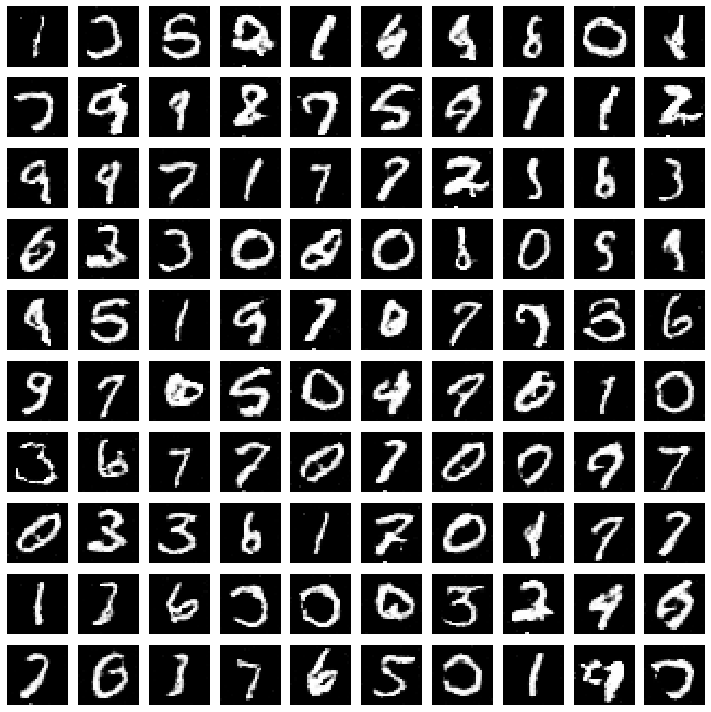

In [0]:
import matplotlib.pyplot as plt


for epoch in range(epochs):  
    for batch in range(steps_per_epoch): 
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        fake_x = generator.predict(noise) # create G(z)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
        #remove below to return to FC scheme
        real_x = real_x.reshape(fake_x.shape)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        # train_on_batch recieves data and desired output
        d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
        d_loss_real = discriminator.train_on_batch(x[batch_size:-1], disc_y[batch_size:-1])
        # train GAN (descriminator weights are fixed)
        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)
        # train reconstructor
        if(batch)
          r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

        

    print(f'Epoch: {epoch} \t Discriminator Loss: {(d_loss_fake+d_loss_real)/2} \t\t Generator Loss: {g_loss} \t\t Reconstructor Loss: {r_loss} ')


def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)





Train sparse dictionary: *RUN ONLY ONCE*

In [0]:
from sklearn.decomposition import DictionaryLearning
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt
from google.colab import files


# init a dictionary learning alg - based on LARS
# TODO - change to all data set and make redundant dictionary
d=DictionaryLearning(n_components=sparse_dim)
# train dictionary
d.fit(x_train)
dictionary = d.components_
savetxt('dictionary.csv', dictionary, delimiter=',')
# download to local machine
files.download('dictionary.csv') 

# we will download to a local file named dictionary_loaded
#*reconstruct* an image for sanity check
representation_vec = d.transform(x_train[1:2,:])
print(representation_vec.shape)
print(dictionary_loaded2.shape)
dictionary_loaded2 = np.transpose(dictionary_loaded2)
representation_vec = np.transpose(representation_vec)
ans = np.matmul(dictionary_loaded2,representation_vec)

plt.figure()
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')

plt.figure()
real_im = x_train[1:2,:]
plt.imshow(real_im.reshape((img_rows, img_cols)), cmap='gray')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-f8731d9080ba>", line 11, in <module>
    d.fit(x_train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_dict_learning.py", line 1238, in fit
    positive_code=self.positive_code)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_dict_learning.py", line 551, in dict_learning
    code, S, dictionary = linalg.svd(X, full_matrices=False)
  File "/usr/local/lib/python3.6/dist-packages/scipy/linalg/decomp_svd.py", line 129, in svd
    full_matrices=full_matrices, overwrite_a=overwrite_a)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._re

KeyboardInterrupt: ignored

reload trained dictionary from local machine - dictionary_loaded.csv

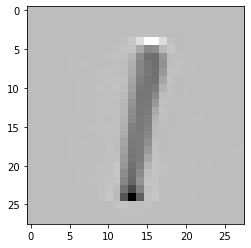

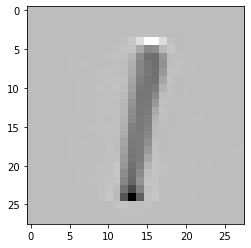

In [3]:
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt

dictionary_loaded2 = loadtxt('dictionary_loaded.csv', delimiter=',')
dictionary_loaded2 = np.array(dictionary_loaded2,dtype=np.float32) # format that is used in keras
# the above dict should enable training a regular gan

# sanity check
dictionary_loaded2 = np.transpose(dictionary_loaded2)
atom1 = (dictionary_loaded2)[:,0]
plt.figure()
plt.imshow(atom1.reshape((img_rows, img_cols)), cmap='gray')

first_atom = np.zeros(784)
first_atom[0] = 1
plt.figure()
ans = np.matmul(dictionary_loaded2,np.transpose(first_atom))
plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')

Sanity test on dictionary

[ 0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436126  0.03435722  0.03435959  0.03436236  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436244  0.03436235  0.03436194  0.0343608
  0.03436666  0.03437388  0.03437438  0.03436788  0.03435844  0.03435289
  0.03437248  0.03442568  0.03441432  0.03436488  0.03437235  0.0343735
  0.03436887  0.03436092  0.03436141  0.03436195  0.03436248  0.03436248
  0.03436248  0.03436248  0.03436248  0.03436248  0.03436251  0.03436249
  0.03436416  0.03436303  0.03435951  0.03435313  0.03436487  0.03439062
  0.03442306  0.03442932  0.0344498   0.03449983  0.03450623  0.0345155
  0.03438831  0.03426142  0.03420307  0.03424123  0.0343274   0.03439284
  0.03437362  0.03435237  0.03436042  0.03436374  0.03

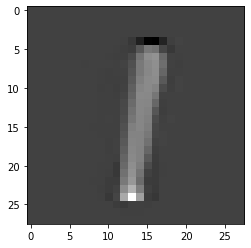

In [0]:
from sklearn.decomposition import DictionaryLearning

print(dictionary_loaded2[:,0] )

atom1 = (dictionary_loaded2)[:,0]
plt.figure()
plt.imshow(atom1.reshape((img_rows, img_cols)), cmap='gray')




In [0]:
L1_weight = 10   # Loss = data_fidelity + L1_weight * L1_norm
thr_value = 0.1

Trying to Create pursuit network for sanity check
Input : Image
Output: Image_r = D*Sparse

In [0]:
# with pursuit and thresholding approach
# generator:
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers


from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast

# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

def create_pursuiter():
    pursuiter = Sequential()
    init = RandomNormal(0,stddev=0.02)
    pursuiter.add(Dense(1024, kernel_initializer=init, input_dim=784,name="pursuiter_input"))
    pursuiter.add(BatchNormalization())
    pursuiter.add(LeakyReLU(0.2))

    pursuiter.add(Dense(1024,kernel_initializer=init,name="pursuiter_2nd"))
    pursuiter.add(BatchNormalization())
    pursuiter.add(LeakyReLU(0.2))

    pursuiter.add(Dense(sparse_dim, kernel_initializer=init,name="pursuiter_3rd"))
    pursuiter.add(BatchNormalization())
    # soft thresholding activation
    pursuiter.add(Activation(soft_threshlding, name='soft_threshlding'))

    #pursuiter.add(Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D'))

    #pursuiter.compile(loss='mean_squared_error', optimizer=optimizer)
    return pursuiter

pursuiter = create_pursuiter()
pursuiter.name = "pursuit_unit"
pursuiter_input = Input(shape=(784,))

sparse_vec = pursuiter(pursuiter_input) 

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)


#pursuiter_full = Model(pursuiter_input, [fake_image_vec,sparse_vec])
#pursuiter_full.compile(loss=['mean_squared_error','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,0])
pursuiter_full = Model(pursuiter_input, fake_image_vec)
pursuiter_full.compile(loss='mean_squared_error', optimizer=optimizer)
pursuiter_full.name = "pursuiter_full"

print(pursuiter_full.summary())
zeros = np.zeros(10000*784)
zeros=zeros.reshape(10000,784)
#model1=pursuiter_full.fit(x_train, [x_train,x_train], validation_data=(x_test, [x_test,zeros]), epochs=epochs, batch_size=16)
model1=pursuiter_full.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=10, batch_size=16)

plot_model(pursuiter_full, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

plot_model(pursuiter, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Model: "pursuiter_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 784)               0         
_________________________________________________________________
pursuit_unit (Sequential)    (None, 784)               2668368   
_________________________________________________________________
mul_in_D (Lambda)            (None, 784)               0         
Total params: 2,668,368
Trainable params: 2,662,704
Non-trainable params: 5,664
_________________________________________________________________
None
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 36s 600us/step - loss: 0.2377 - val_loss: 1676.1844
Epoch 2/10
60000/60000 [==============================] - 32s 534us/step - loss: 0.0782 - val_loss: 1207.9882
Epoch 3/10
50416/60000 [========================>.....] - ETA: 4s - loss: 0.0647

{'val_loss': [1684.7371626953125, 913.1123381835938, 1002.3588461914062, 843.9326375976563, 894.4054498046875, 1029.3403288085938, 990.5882129882813, 1007.5419294921875, 1054.5893450195313, 1112.1804073242188], 'loss': [0.26607393118739125, 0.08156835175454616, 0.06499877068698406, 0.058239109587669376, 0.05403695854942004, 0.05145916385650635, 0.04976319066683451, 0.048136981893579164, 0.0471495400339365, 0.04572537525395552]}


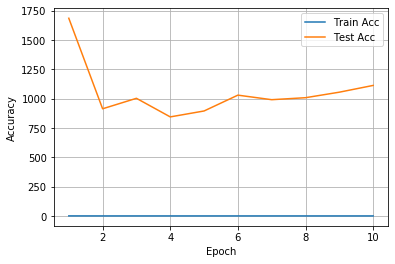

In [0]:
plt.figure()
print(model1.history)
plt.plot(range(1,len(model1.history['loss'])+1),model1.history['loss'], label='Train Acc')
plt.plot(range(1,len(model1.history['val_loss'])+1),model1.history['val_loss'], label='Test Acc')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

average support on train=  641.4687666666666
average support on test=  782.9436
Im_r, Im
sparse vector dim =  (1, 784)
sparse vector non zeros =  781
sparse vec max element is =  304.58716
positive number =  414
sparse vec average positive = 36.376102
negatives number =  367
sparse vec average negative = -36.284073


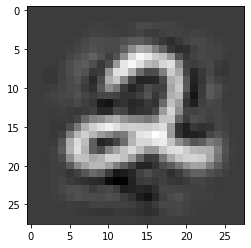

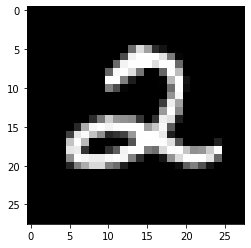

In [0]:
import random

x_train_pred = pursuiter.predict(x_train)
print("average support on train= ", np.count_nonzero(x_train_pred)/60000)

x_test_pred = pursuiter.predict(x_test)
print("average support on test= ", np.count_nonzero(x_test_pred)/10000)

im = random.randrange(0, 9999)
x_train.shape
x = np.array([x_test[im,:]])

# plt results
print("Im_r, Im")
plt.figure()
plt.imshow(pursuiter_full.predict(x)[0].reshape((img_rows, img_cols)), cmap='gray')

plt.figure()
plt.imshow(x[0].reshape((img_rows, img_cols)), cmap='gray')

# is it sparse?
pred = pursuiter.predict(x)
print("sparse vector dim = ", pred.shape)
print("sparse vector non zeros = ", np.count_nonzero(pred))
print("sparse vec max element is = ",np.max(pred))
print("positive number = ", np.count_nonzero(pred[pred>0]))
print("sparse vec average positive =",np.mean(pred[pred>0]))
print("negatives number = ", np.count_nonzero(pred[pred<0]))
print("sparse vec average negative =",np.mean(pred[pred<0]))


GAN + Reconstructor

Model: "Gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
init (Dense)                 (None, 256)               25856     
_________________________________________________________________
BN1 (BatchNormalization)     (None, 256)               1024      
_________________________________________________________________
Activation1 (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 512)               131584    
_________________________________________________________________
BN2 (BatchNormalization)     (None, 512)               2048      
_________________________________________________________________
Activation2 (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 1024)              525312  

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


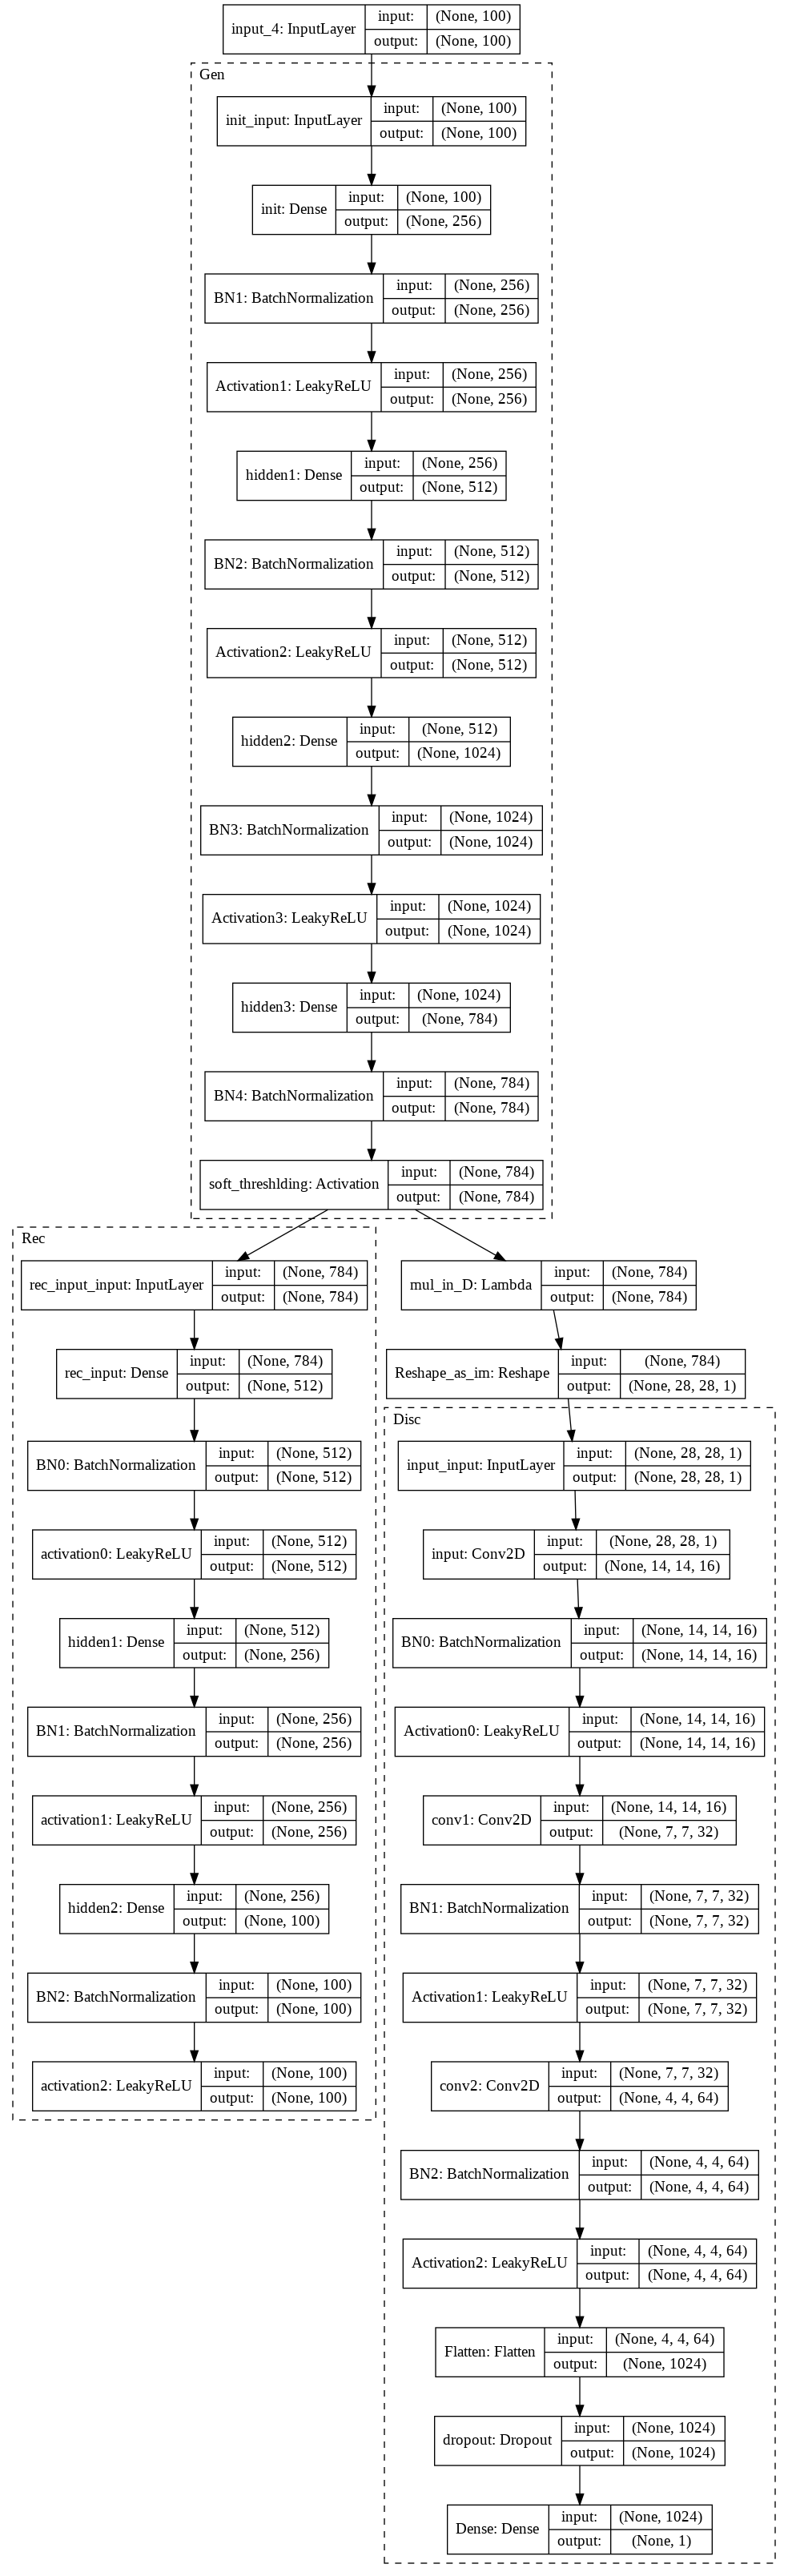

In [17]:
# with pursuit and thresholding approach
# generator:
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers
from keras.losses import kullback_leibler_divergence, binary_crossentropy


from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast

# costum loss - symmetric KL divergence

def my_loss(y_actual,y_pred):
  return kullback_leibler_divergence(y_actual,y_pred)
  #return 0.5*(kullback_leibler_divergence(y_actual,y_pred) + binary_crossentropy(y_actual,y_pred))


# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

# input: sparse vec size
# output: noise size
def create_reconstructor():
    reconstructor = Sequential()
    init = RandomNormal(0,stddev=0.02)

    reconstructor.add(Dense(512,  kernel_initializer=init, input_dim=sparse_dim,name="rec_input"))
    reconstructor.add(BatchNormalization(name="BN0"))
    reconstructor.add(LeakyReLU(0.2,name="activation0"))

    reconstructor.add(Dense(256, kernel_initializer=init,name="hidden1"))
    reconstructor.add(BatchNormalization(name="BN1"))
    reconstructor.add(LeakyReLU(0.2,name="activation1"))

    reconstructor.add(Dense(noise_dim, kernel_initializer=init,name="hidden2"))
    reconstructor.add(BatchNormalization(name="BN2"))
    reconstructor.add(LeakyReLU(0.2,name="activation2"))

    #reconstructor.compile(loss='mean_squared_error', optimizer='sgd')
    return reconstructor

# input: noise size
# output: sparse vec size
def create_generator():
    generator = Sequential()
    init = RandomNormal(0,stddev=0.02)
    generator.add(Dense(256, kernel_initializer=init, input_dim=noise_dim,name="init"))
    generator.add(BatchNormalization(name="BN1"))
    generator.add(LeakyReLU(0.2,name="Activation1"))

    generator.add(Dense(512,kernel_initializer=init,name="hidden1"))
    generator.add(BatchNormalization(name="BN2"))
    generator.add(LeakyReLU(0.2,name="Activation2"))

    generator.add(Dense(1024,kernel_initializer=init,name="hidden2"))
    generator.add(BatchNormalization(name="BN3"))
    generator.add(LeakyReLU(0.2,name="Activation3"))

    generator.add(Dense(sparse_dim, kernel_initializer=init,name="hidden3"))
    # soft thresholding activation
    generator.add(BatchNormalization(name="BN4"))
    generator.add(Activation(soft_threshlding, name='soft_threshlding'))
    return generator

# input: image size
# output: 1 number - 1 real 0 fake
# descriminator:
def create_descriminator():
    discriminator = Sequential()
    #16 - better
    discriminator.add(Conv2D(16, (3, 3), strides=(2,2),padding='same', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels),name="input"))
    discriminator.add(BatchNormalization(name="BN0"))
    discriminator.add(LeakyReLU(0.2,name="Activation0"))
    #32 - better
    discriminator.add(Conv2D(32, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv1"))
    discriminator.add(BatchNormalization(name="BN1"))
    discriminator.add(LeakyReLU(0.2,name="Activation1"))
    # 64 - better
    discriminator.add(Conv2D(64, (3, 3), strides=(2,2), padding='same',  kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="conv2"))
    discriminator.add(BatchNormalization(name="BN2"))
    discriminator.add(LeakyReLU(0.2,name="Activation2"))
    
    discriminator.add(Flatten(name="Flatten"))
    discriminator.add(Dropout(0.4,name="dropout"))
    discriminator.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01),kernel_initializer=RandomNormal(0, 0.02),name="Dense"))   # 1 number which indicates real / fake
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

# build GAN
discriminator = create_descriminator()
generator = create_generator()
reconstructor = create_reconstructor()
# naming:
discriminator.name = "Disc"
generator.name = "Gen"
reconstructor.name = "Rec"
#
discriminator.trainable = False   # will be trained separately, not as GAN

gan_input = Input(shape=(noise_dim,))

# G(z) is a sparse vector
sparse_vec = generator(gan_input)   # sparse_dim size - it is thresholded

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)
# reshape to image size - will be inserted to discriminator
fake_image = Reshape((img_rows, img_cols, channels),name="Reshape_as_im")(fake_image_vec)

gan_output = discriminator(fake_image)  # the descriminator output
vae_output = reconstructor(sparse_vec)  # the reconstructor output

vae = Model(gan_input, vae_output)
vae.compile(loss='mean_squared_error', optimizer='sgd')

# todo - double output double loss
gan = Model(gan_input, [gan_output,sparse_vec])
gan.compile(loss=[my_loss,'mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])

print(generator.summary())
print(discriminator.summary())
print(reconstructor.summary())
complete = Model(gan_input,[gan_output,vae_output])
plot_model(complete, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)


2nd approach train

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  0  d_fake_as_real =  0.5019685626029968  support =  0.0


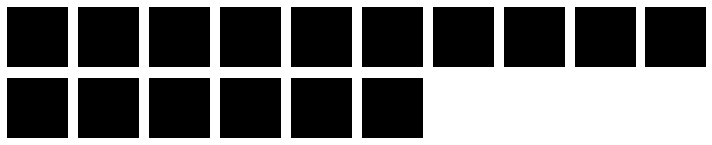

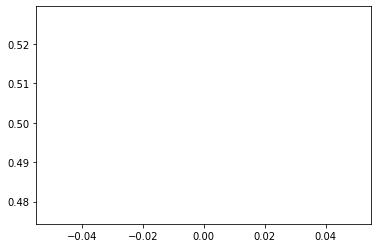

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  100  d_fake_as_real =  0.3031039834022522  support =  600.625


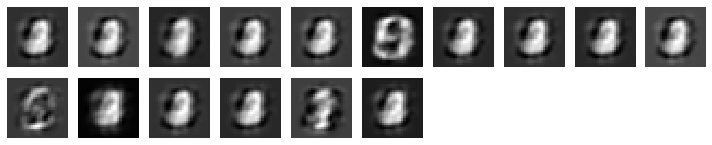

results after iter  200  d_fake_as_real =  0.4368094205856323  support =  626.4375


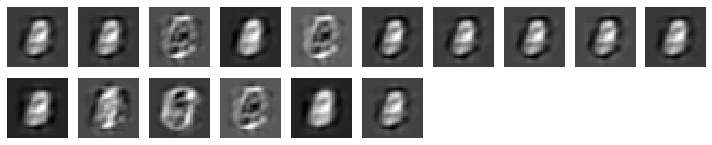

results after iter  300  d_fake_as_real =  0.41814863681793213  support =  549.8125


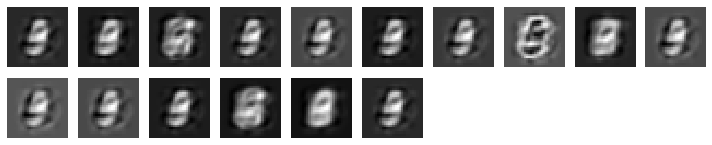

results after iter  400  d_fake_as_real =  0.4520927667617798  support =  611.75


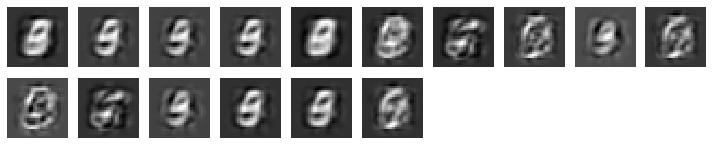

results after iter  500  d_fake_as_real =  0.44149088859558105  support =  545.8125


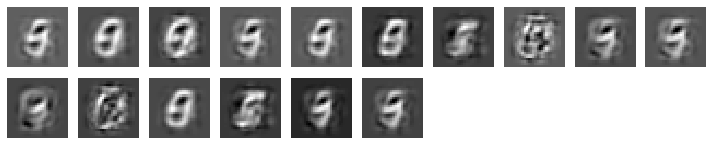

results after iter  600  d_fake_as_real =  0.43201756477355957  support =  567.4375


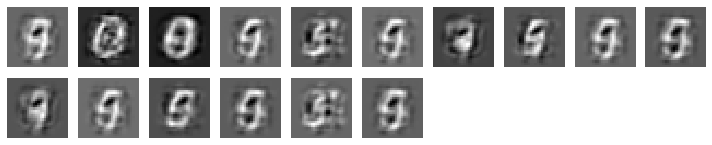

results after iter  700  d_fake_as_real =  0.4245288670063019  support =  517.0


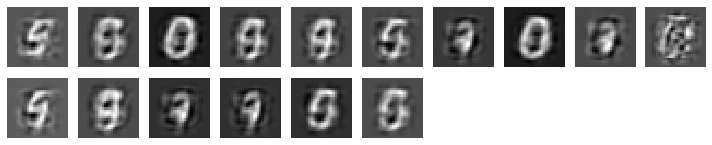

results after iter  800  d_fake_as_real =  0.41978299617767334  support =  460.75


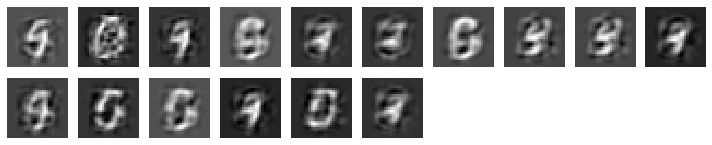

results after iter  900  d_fake_as_real =  0.42246782779693604  support =  480.625


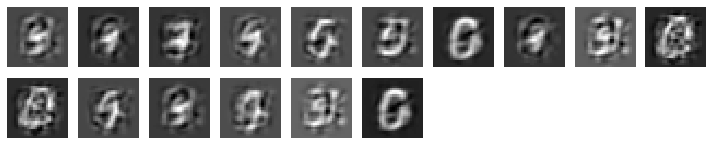

results after iter  1000  d_fake_as_real =  0.41404929757118225  support =  420.125


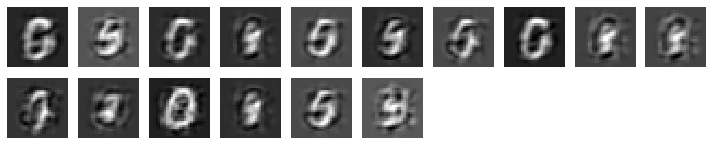

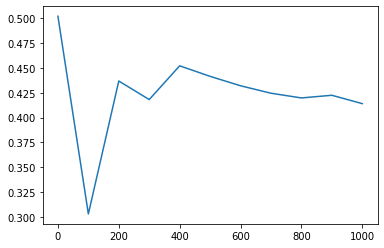

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  1100  d_fake_as_real =  0.4140387773513794  support =  435.25


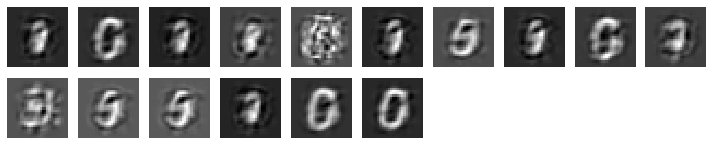

results after iter  1200  d_fake_as_real =  0.41656655073165894  support =  524.8125


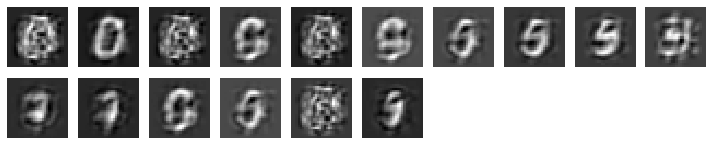

results after iter  1300  d_fake_as_real =  0.40659523010253906  support =  419.6875


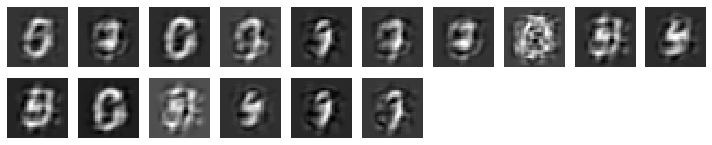

results after iter  1400  d_fake_as_real =  0.4090614318847656  support =  418.75


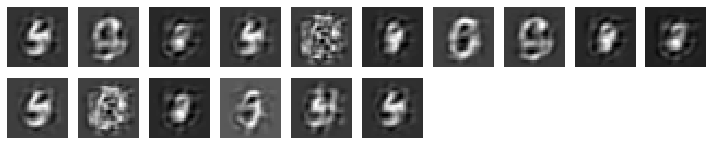

results after iter  1500  d_fake_as_real =  0.41338610649108887  support =  409.75


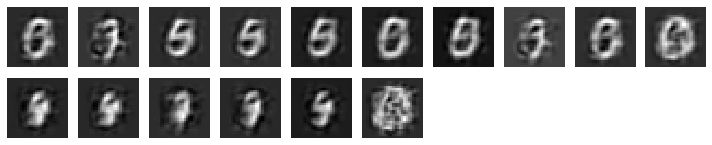

results after iter  1600  d_fake_as_real =  0.4096642732620239  support =  411.3125


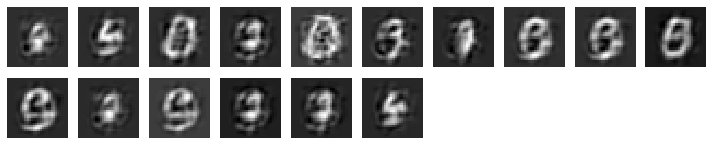

results after iter  1700  d_fake_as_real =  0.40970751643180847  support =  481.9375


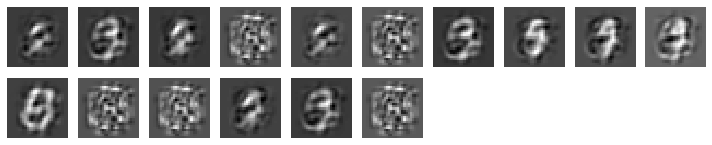

results after iter  1800  d_fake_as_real =  0.4087914824485779  support =  404.0


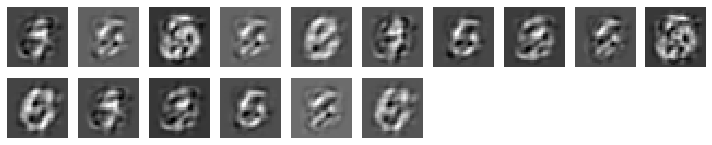

results after iter  1900  d_fake_as_real =  0.4093945324420929  support =  382.3125


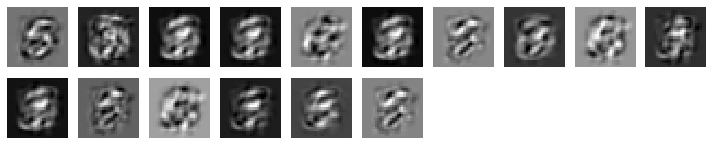

results after iter  2000  d_fake_as_real =  0.40927863121032715  support =  334.75


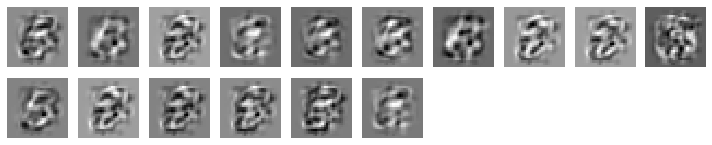

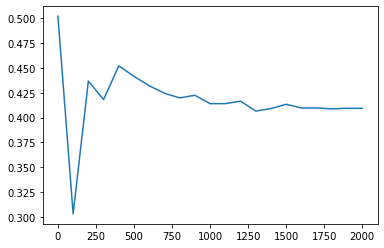

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  2100  d_fake_as_real =  0.405988872051239  support =  275.0625


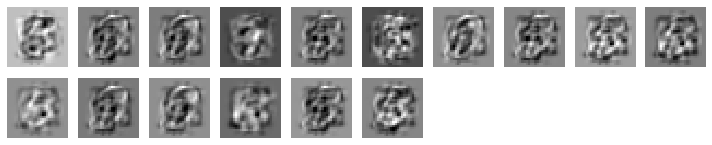

results after iter  2200  d_fake_as_real =  0.4066886901855469  support =  319.1875


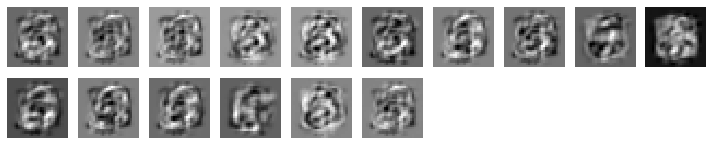

results after iter  2300  d_fake_as_real =  0.405917227268219  support =  324.125


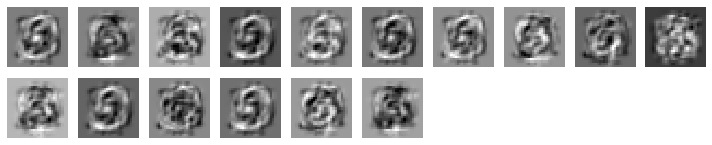

results after iter  2400  d_fake_as_real =  0.40311604738235474  support =  248.0


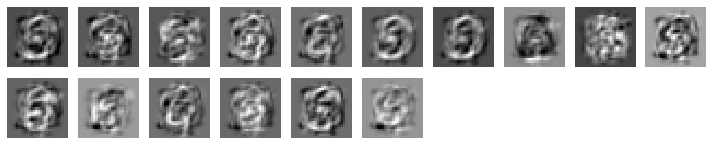

results after iter  2500  d_fake_as_real =  0.3831467628479004  support =  212.375


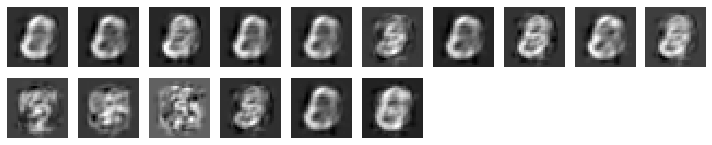

results after iter  2600  d_fake_as_real =  0.38177910447120667  support =  264.5


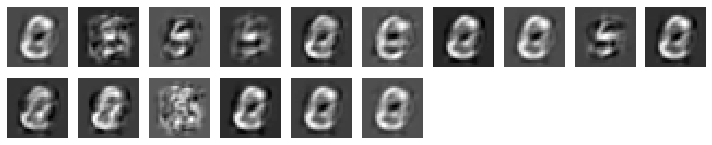

results after iter  2700  d_fake_as_real =  0.38546544313430786  support =  231.3125


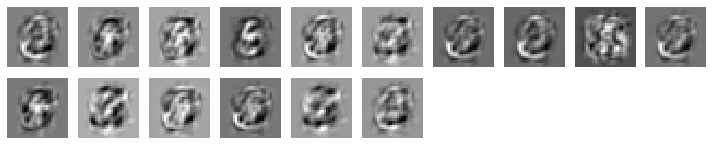

results after iter  2800  d_fake_as_real =  0.38552963733673096  support =  193.75


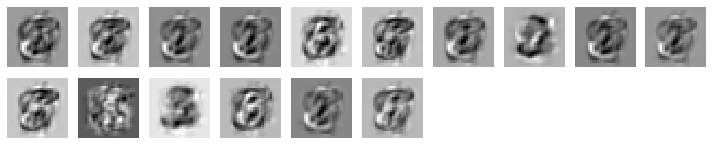

results after iter  2900  d_fake_as_real =  0.3851059675216675  support =  225.375


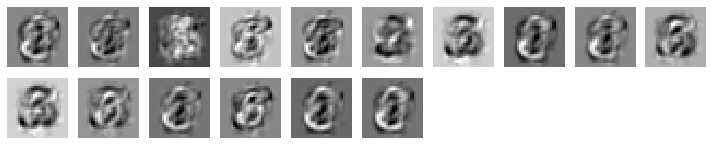

results after iter  3000  d_fake_as_real =  0.3824472427368164  support =  207.75


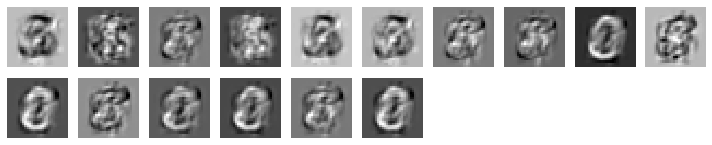

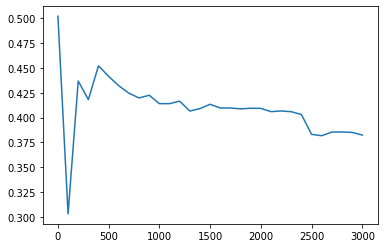

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  3100  d_fake_as_real =  0.37482285499572754  support =  216.4375


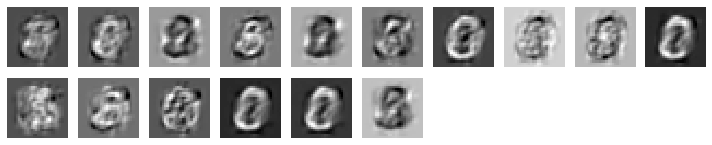

results after iter  3200  d_fake_as_real =  0.25717687606811523  support =  151.5625


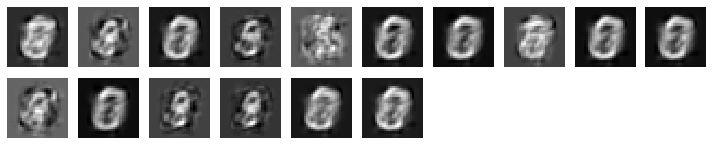

results after iter  3300  d_fake_as_real =  0.23450860381126404  support =  200.875


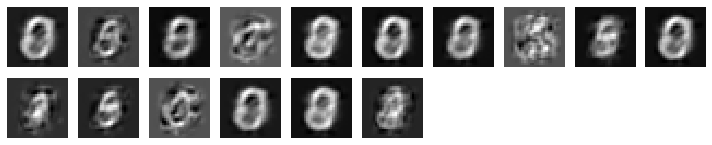

results after iter  3400  d_fake_as_real =  0.21445077657699585  support =  281.5


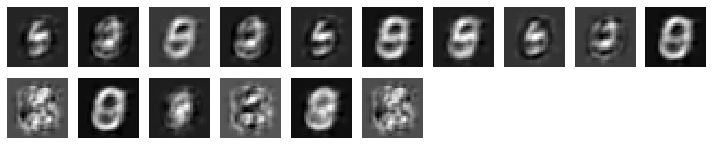

results after iter  3500  d_fake_as_real =  0.19629573822021484  support =  231.8125


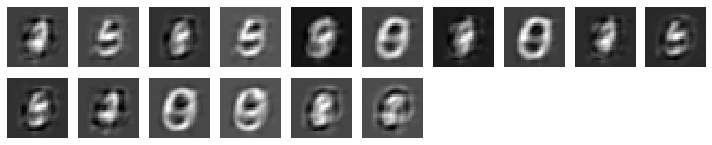

results after iter  3600  d_fake_as_real =  0.18028466403484344  support =  353.125


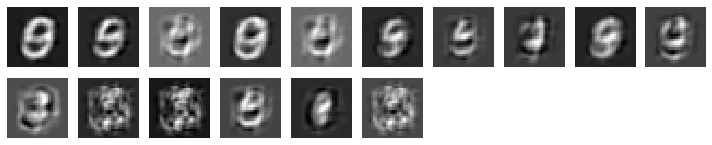

results after iter  3700  d_fake_as_real =  0.17442792654037476  support =  321.0625


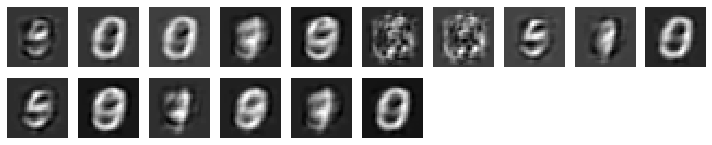

Epoch: 0 	 Discriminator Loss_fake: 0.39732620120048523 	 Discriminator Loss_real: 0.05895673483610153		 Generator Loss: [8.7659855, 5.1819205, 0.35401195]


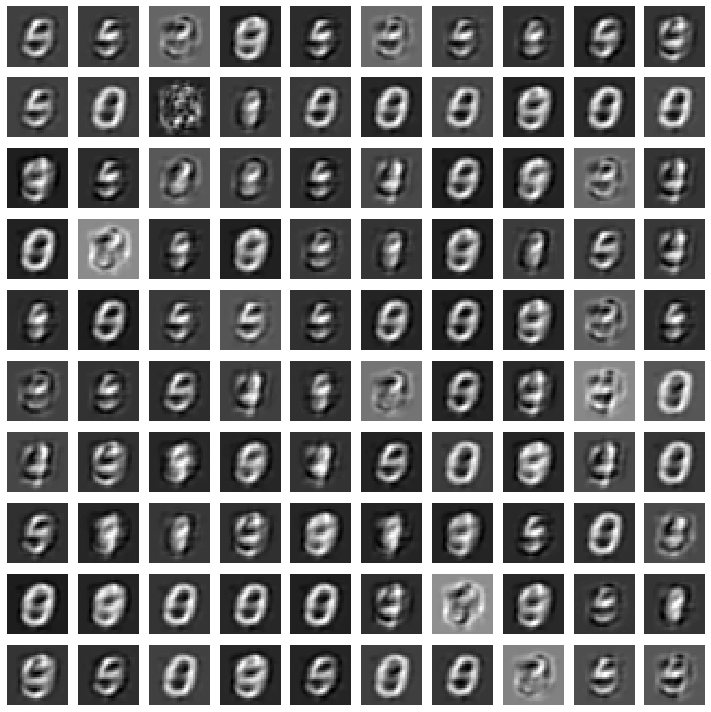

results after iter  3800  d_fake_as_real =  0.17585235834121704  support =  374.0625


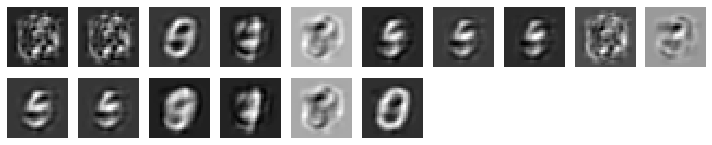

results after iter  3900  d_fake_as_real =  0.1942947506904602  support =  273.9375


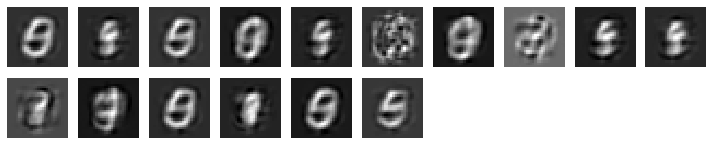

results after iter  4000  d_fake_as_real =  0.18982531130313873  support =  317.125


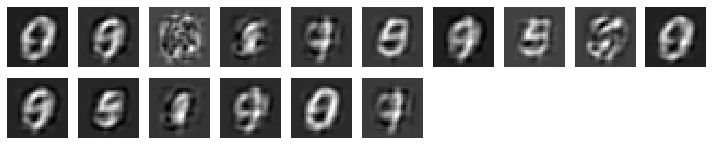

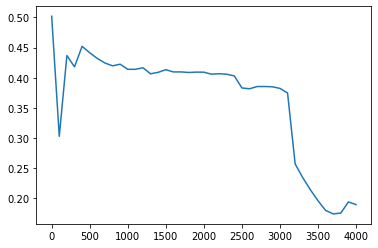

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  4100  d_fake_as_real =  0.1905578374862671  support =  346.75


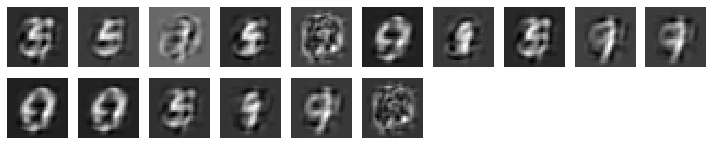

results after iter  4200  d_fake_as_real =  0.19926925003528595  support =  322.875


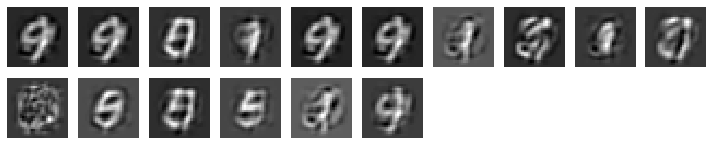

results after iter  4300  d_fake_as_real =  0.2019243836402893  support =  312.6875


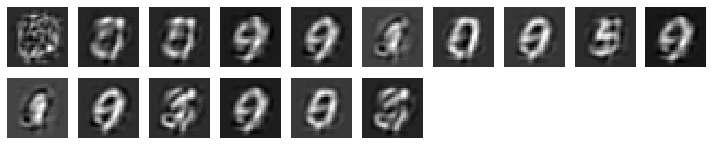

results after iter  4400  d_fake_as_real =  0.21805815398693085  support =  316.3125


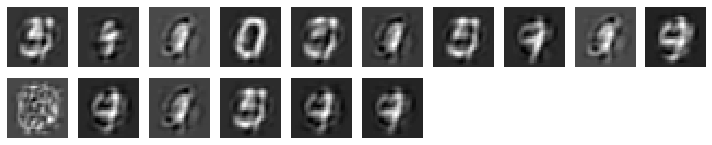

results after iter  4500  d_fake_as_real =  0.21364043653011322  support =  320.25


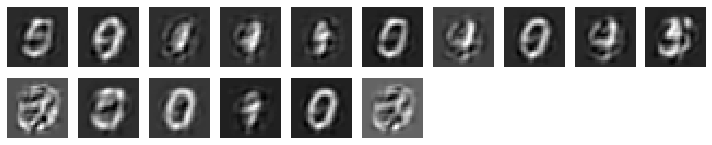

results after iter  4600  d_fake_as_real =  0.21474406123161316  support =  298.0


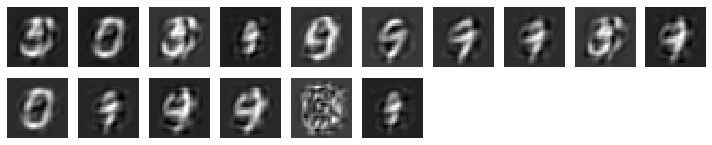

results after iter  4700  d_fake_as_real =  0.23174557089805603  support =  280.6875


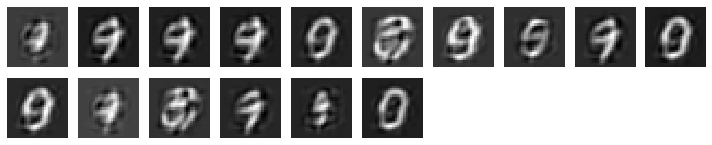

results after iter  4800  d_fake_as_real =  0.22305692732334137  support =  289.0


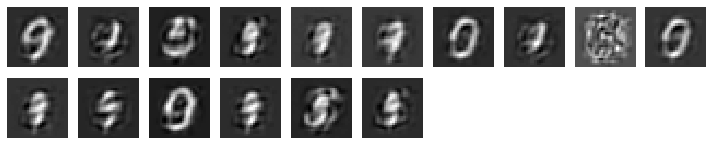

results after iter  4900  d_fake_as_real =  0.23368343710899353  support =  324.625


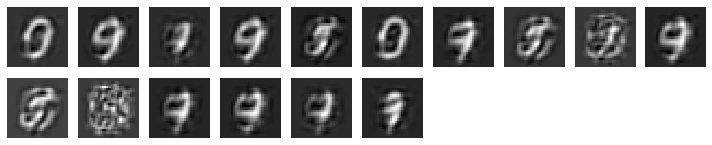

results after iter  5000  d_fake_as_real =  0.23784449696540833  support =  272.8125


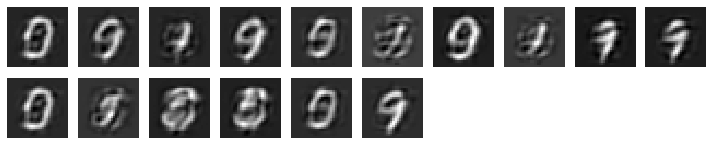

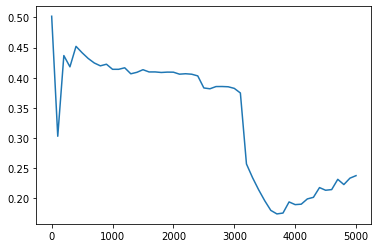

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  5100  d_fake_as_real =  0.2856680452823639  support =  258.9375


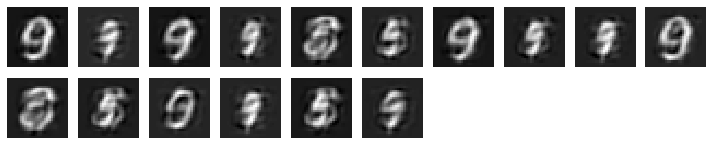

results after iter  5200  d_fake_as_real =  0.26819467544555664  support =  306.75


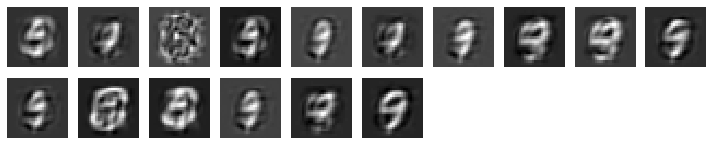

results after iter  5300  d_fake_as_real =  0.2580476403236389  support =  323.3125


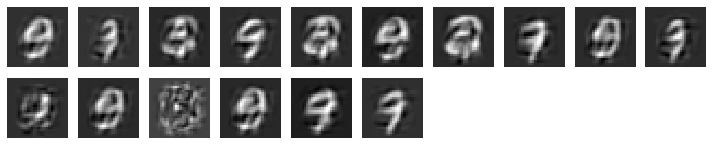

results after iter  5400  d_fake_as_real =  0.2506887912750244  support =  349.8125


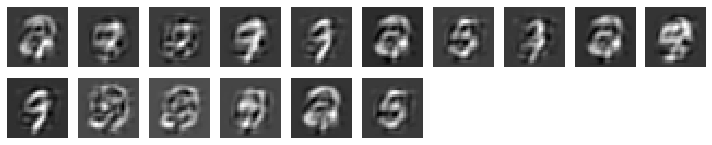

results after iter  5500  d_fake_as_real =  0.25534623861312866  support =  310.125


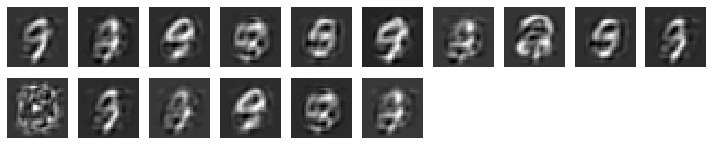

results after iter  5600  d_fake_as_real =  0.233387753367424  support =  358.875


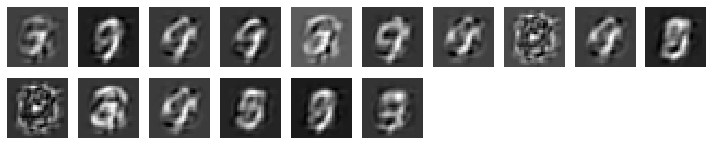

results after iter  5700  d_fake_as_real =  0.2373427152633667  support =  292.5625


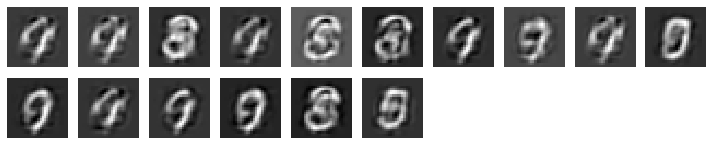

results after iter  5800  d_fake_as_real =  0.24241435527801514  support =  340.4375


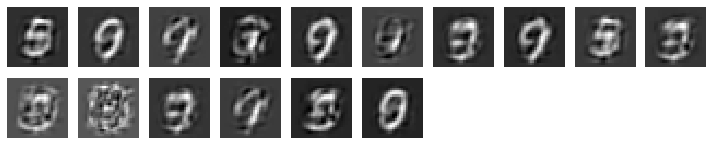

results after iter  5900  d_fake_as_real =  0.25826287269592285  support =  293.3125


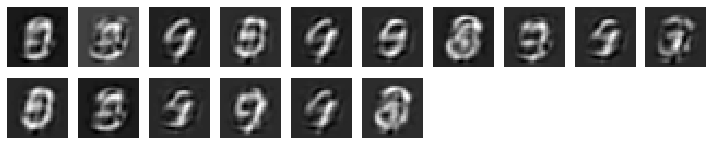

results after iter  6000  d_fake_as_real =  0.25545454025268555  support =  311.9375


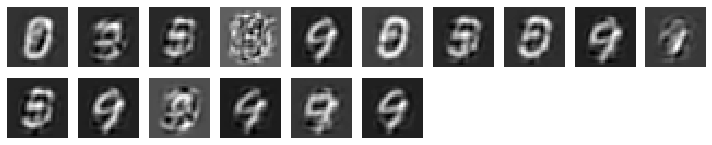

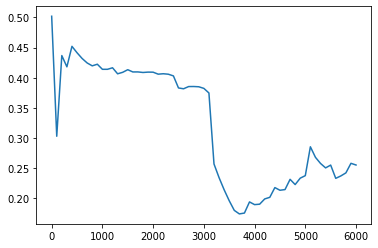

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  6100  d_fake_as_real =  0.2578807771205902  support =  265.1875


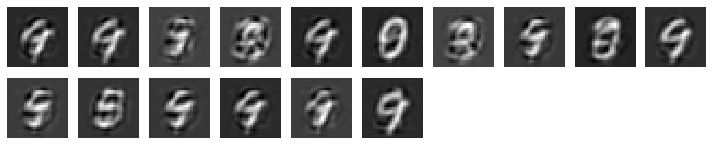

results after iter  6200  d_fake_as_real =  0.25739848613739014  support =  273.125


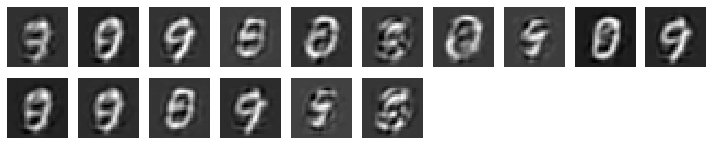

results after iter  6300  d_fake_as_real =  0.2618825137615204  support =  298.5625


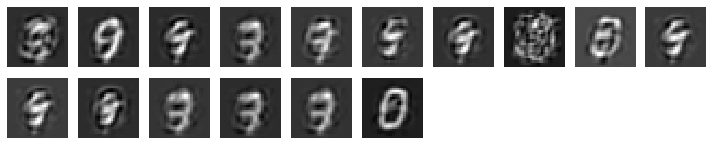

results after iter  6400  d_fake_as_real =  0.3051522374153137  support =  303.3125


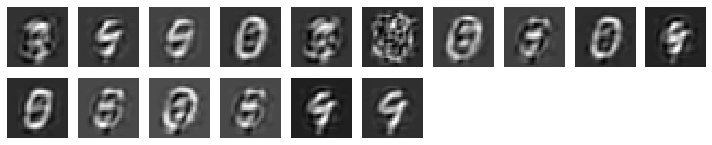

results after iter  6500  d_fake_as_real =  0.26776689291000366  support =  286.625


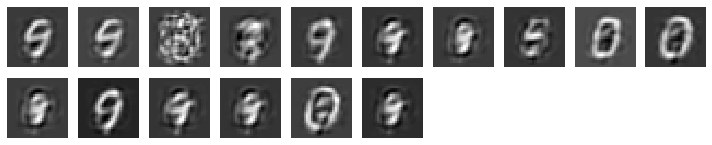

results after iter  6600  d_fake_as_real =  0.2593415677547455  support =  335.0625


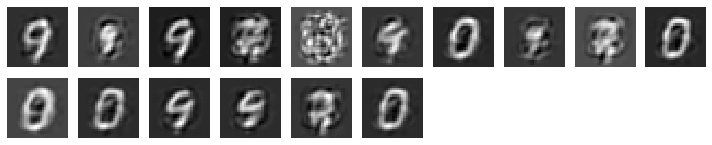

results after iter  6700  d_fake_as_real =  0.2941938042640686  support =  280.1875


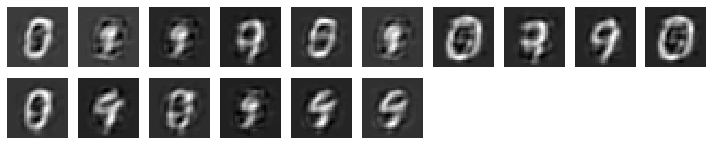

results after iter  6800  d_fake_as_real =  0.2512602210044861  support =  260.625


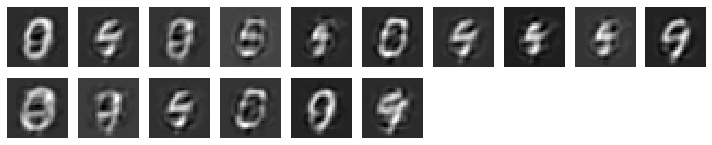

results after iter  6900  d_fake_as_real =  0.24693015217781067  support =  293.4375


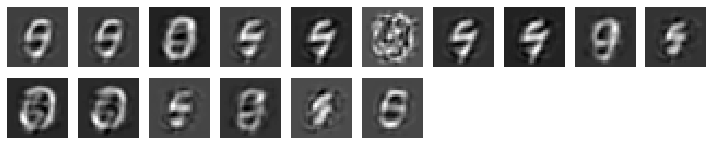

results after iter  7000  d_fake_as_real =  0.24783959984779358  support =  278.375


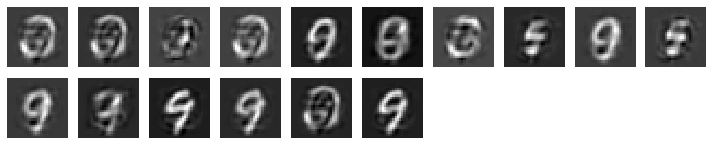

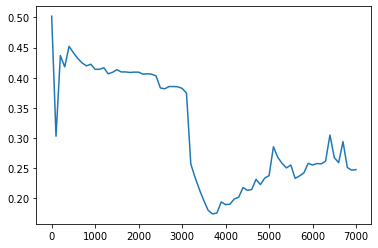

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  7100  d_fake_as_real =  0.2538153827190399  support =  318.625


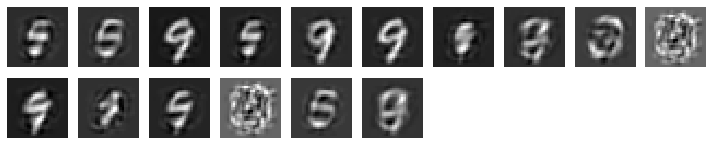

results after iter  7200  d_fake_as_real =  0.26222899556159973  support =  388.8125


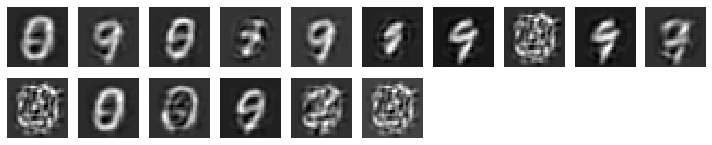

results after iter  7300  d_fake_as_real =  0.3033924102783203  support =  269.8125


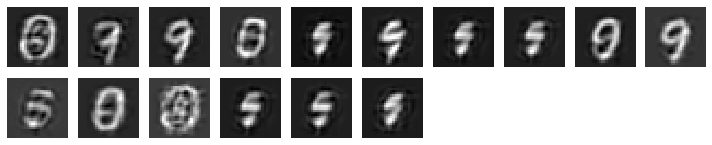

results after iter  7400  d_fake_as_real =  0.23829296231269836  support =  261.0


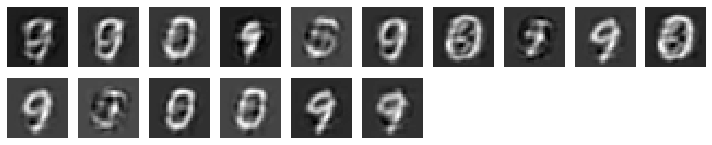

Epoch: 1 	 Discriminator Loss_fake: 0.39498916268348694 	 Discriminator Loss_real: 0.04380103945732117		 Generator Loss: [6.537287, 4.419021, 0.20784295]


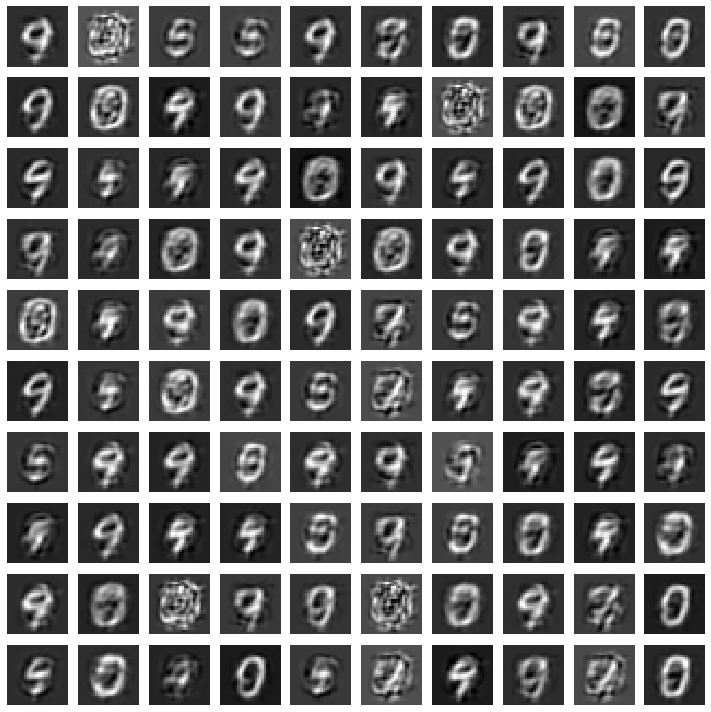

results after iter  7500  d_fake_as_real =  0.23050042986869812  support =  304.5


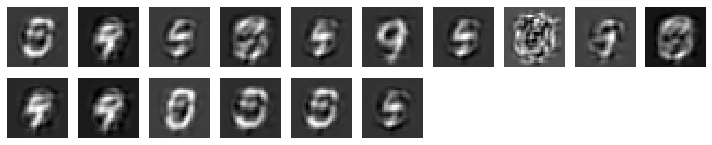

results after iter  7600  d_fake_as_real =  0.21805599331855774  support =  333.3125


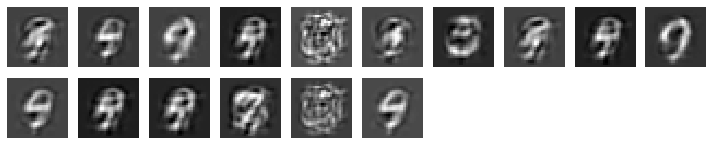

results after iter  7700  d_fake_as_real =  0.22247086465358734  support =  330.5


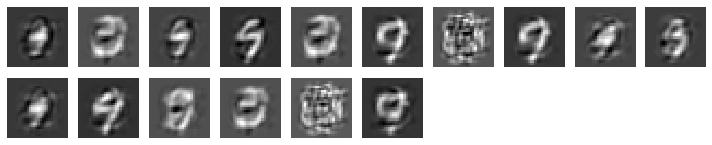

results after iter  7800  d_fake_as_real =  0.22170886397361755  support =  364.625


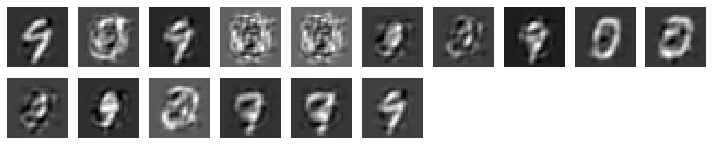

results after iter  7900  d_fake_as_real =  0.2209886908531189  support =  326.75


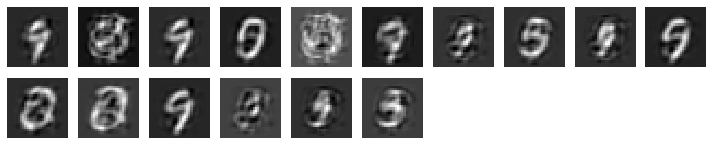

results after iter  8000  d_fake_as_real =  0.22381600737571716  support =  286.375


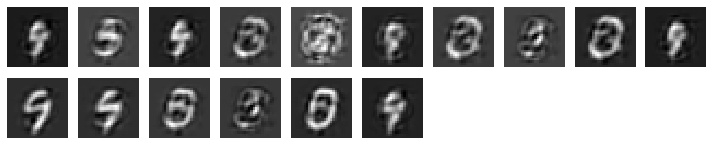

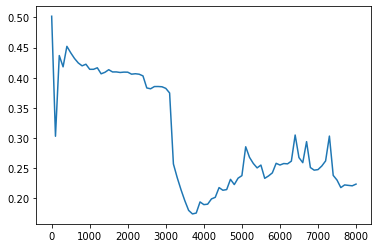

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  8100  d_fake_as_real =  0.23320810496807098  support =  249.0


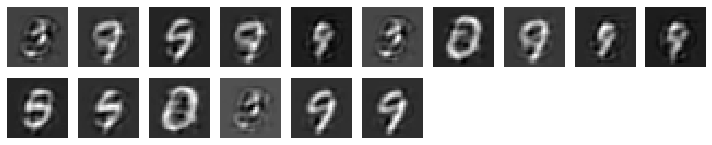

results after iter  8200  d_fake_as_real =  0.286952942609787  support =  279.0625


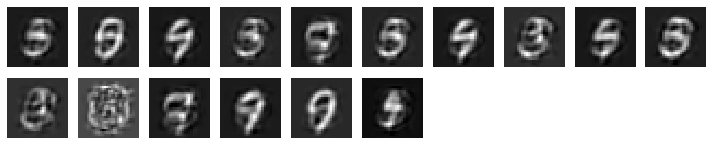

results after iter  8300  d_fake_as_real =  0.26246291399002075  support =  284.375


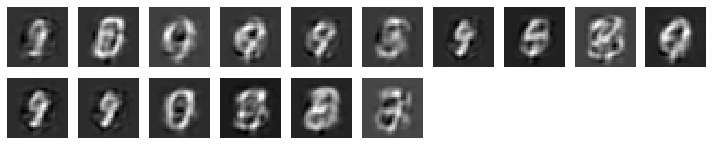

results after iter  8400  d_fake_as_real =  0.25247108936309814  support =  340.5


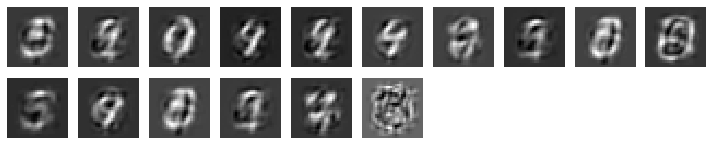

results after iter  8500  d_fake_as_real =  0.24604453146457672  support =  385.1875


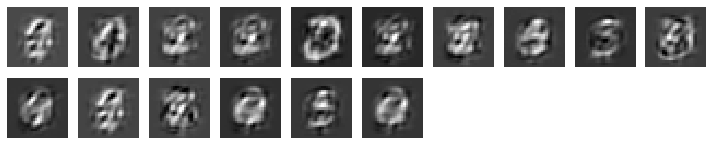

results after iter  8600  d_fake_as_real =  0.24131038784980774  support =  366.3125


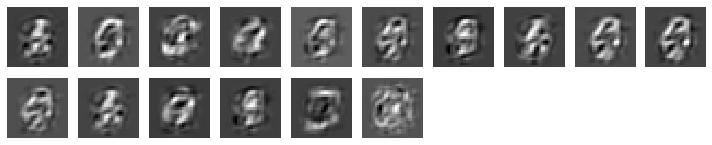

results after iter  8700  d_fake_as_real =  0.23138479888439178  support =  338.9375


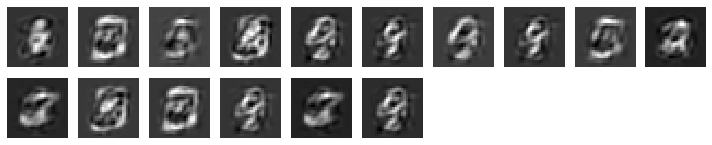

results after iter  8800  d_fake_as_real =  0.235154926776886  support =  348.25


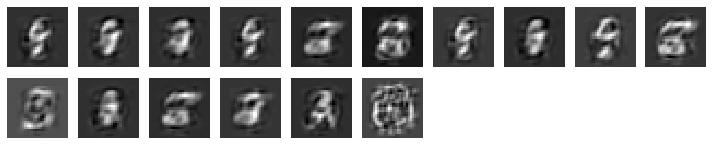

results after iter  8900  d_fake_as_real =  0.242423415184021  support =  361.875


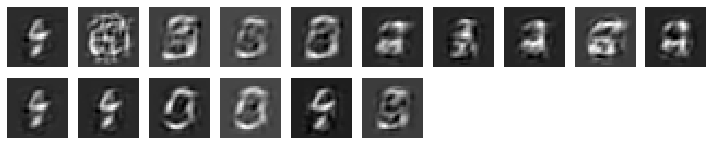

results after iter  9000  d_fake_as_real =  0.23990066349506378  support =  315.4375


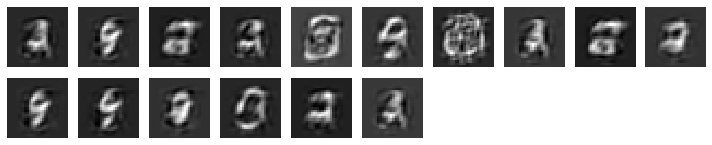

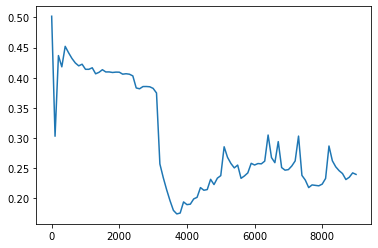

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  9100  d_fake_as_real =  0.22242850065231323  support =  371.5


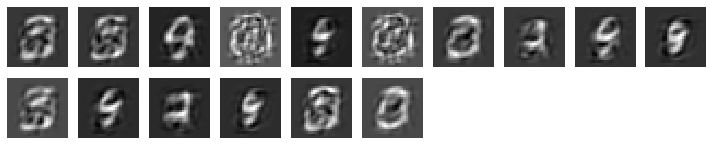

results after iter  9200  d_fake_as_real =  0.22272023558616638  support =  306.4375


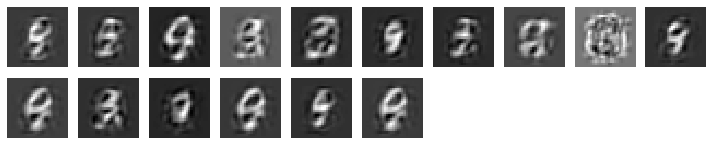

results after iter  9300  d_fake_as_real =  0.21205371618270874  support =  335.9375


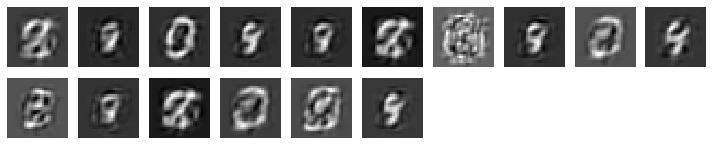

results after iter  9400  d_fake_as_real =  0.1984533816576004  support =  304.1875


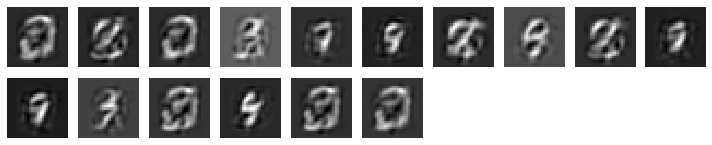

results after iter  9500  d_fake_as_real =  0.2391812801361084  support =  272.0625


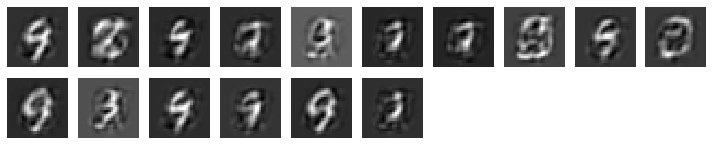

results after iter  9600  d_fake_as_real =  0.20502153038978577  support =  280.4375


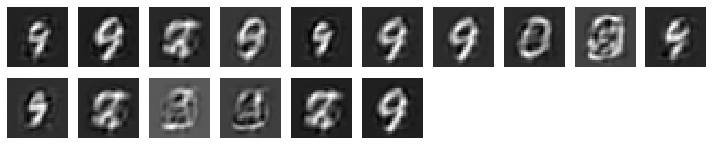

results after iter  9700  d_fake_as_real =  0.20592691004276276  support =  287.9375


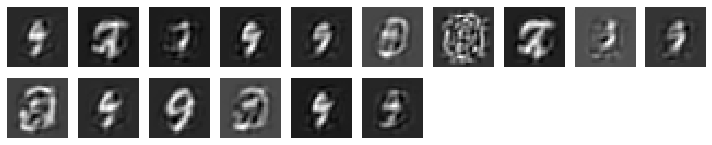

results after iter  9800  d_fake_as_real =  0.21192999184131622  support =  282.75


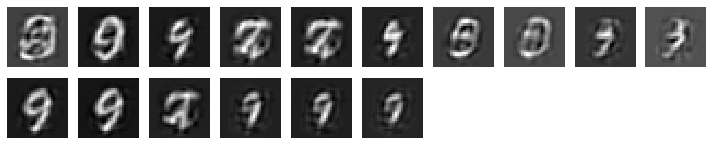

results after iter  9900  d_fake_as_real =  0.19981437921524048  support =  329.875


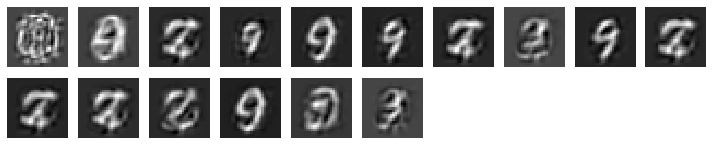

results after iter  10000  d_fake_as_real =  0.20249173045158386  support =  343.3125


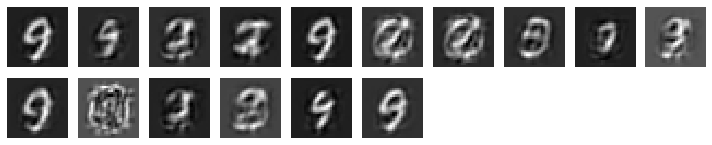

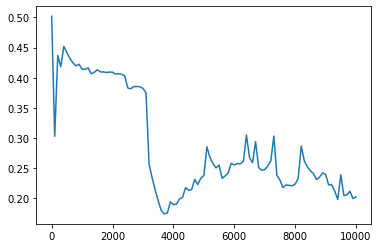

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  10100  d_fake_as_real =  0.21337789297103882  support =  296.8125


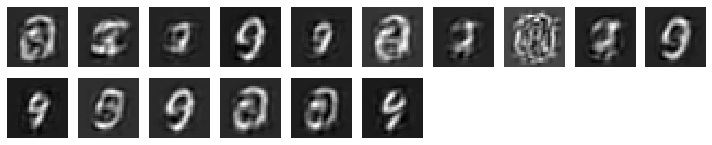

results after iter  10200  d_fake_as_real =  0.2167471945285797  support =  300.25


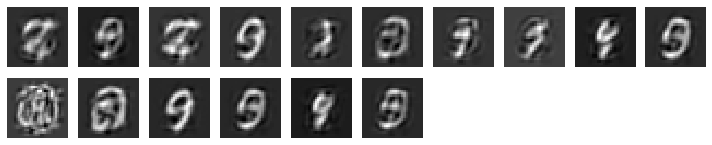

results after iter  10300  d_fake_as_real =  0.20656245946884155  support =  316.875


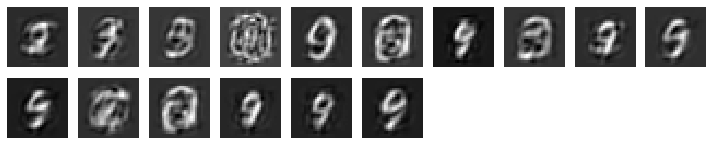

results after iter  10400  d_fake_as_real =  0.2097615897655487  support =  334.125


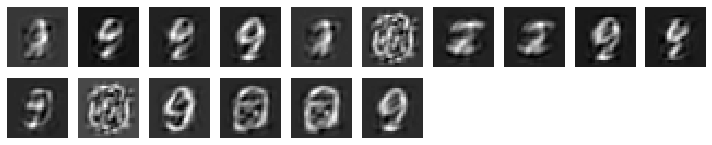

results after iter  10500  d_fake_as_real =  0.21736747026443481  support =  260.0625


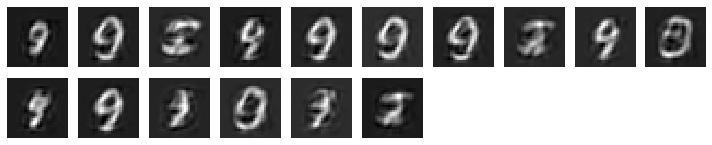

results after iter  10600  d_fake_as_real =  0.22033312916755676  support =  327.5625


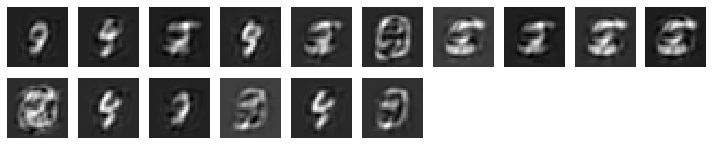

results after iter  10700  d_fake_as_real =  0.2256028950214386  support =  381.75


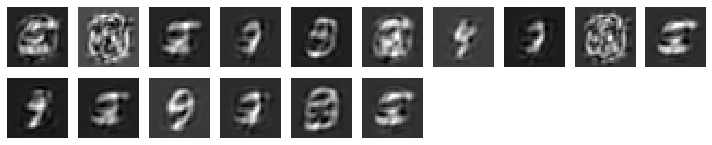

results after iter  10800  d_fake_as_real =  0.23036710917949677  support =  279.125


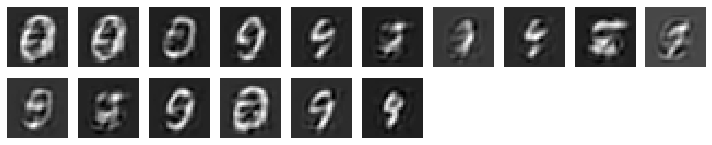

results after iter  10900  d_fake_as_real =  0.1849212348461151  support =  330.0625


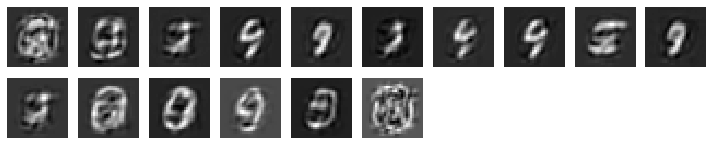

results after iter  11000  d_fake_as_real =  0.17768043279647827  support =  264.5


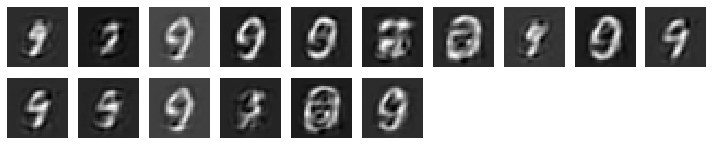

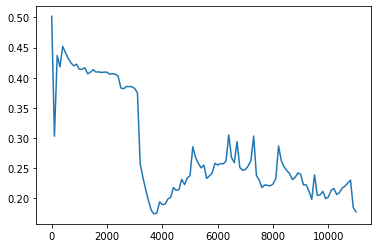

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  11100  d_fake_as_real =  0.17996512353420258  support =  237.8125


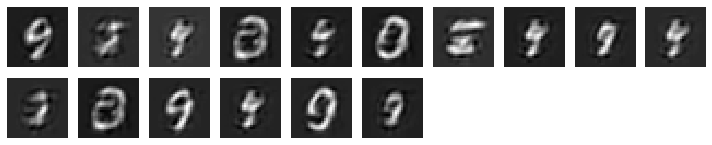

results after iter  11200  d_fake_as_real =  0.1873174011707306  support =  327.8125


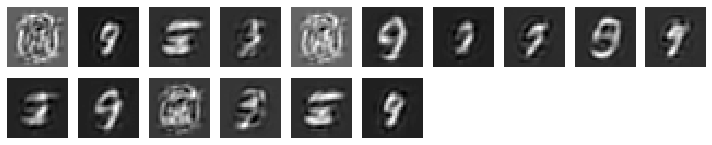

Epoch: 2 	 Discriminator Loss_fake: 0.3557969629764557 	 Discriminator Loss_real: 0.027078330516815186		 Generator Loss: [9.37287, 7.4146643, 0.19330189]


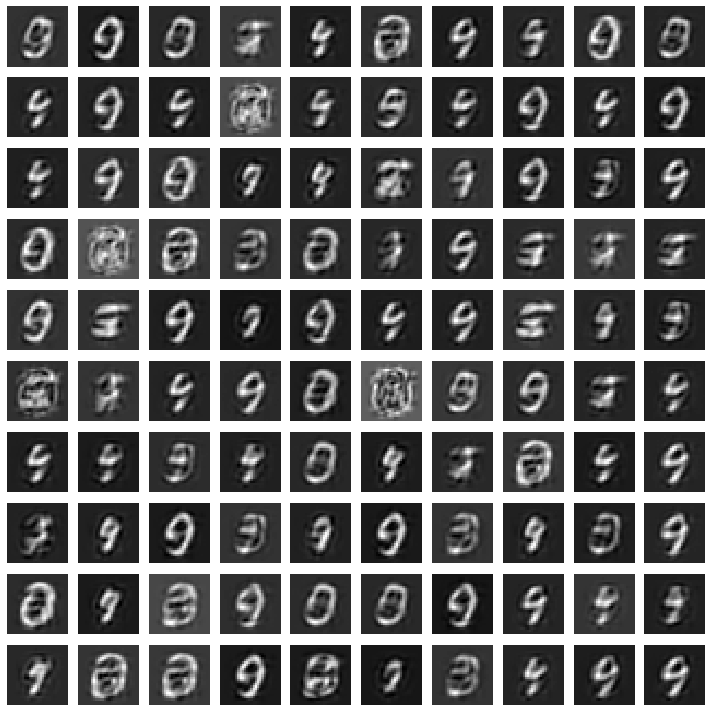

results after iter  11300  d_fake_as_real =  0.19677668809890747  support =  272.4375


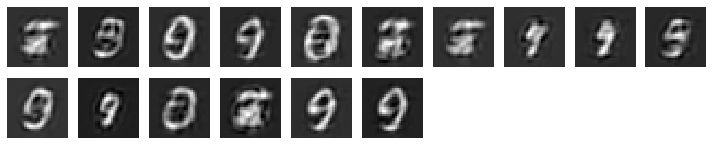

results after iter  11400  d_fake_as_real =  0.21718472242355347  support =  260.5


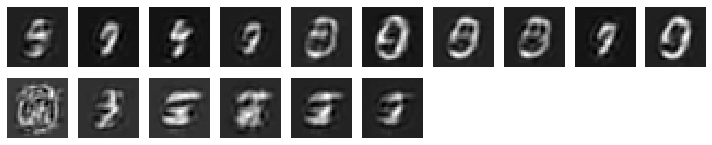

results after iter  11500  d_fake_as_real =  0.21575763821601868  support =  262.75


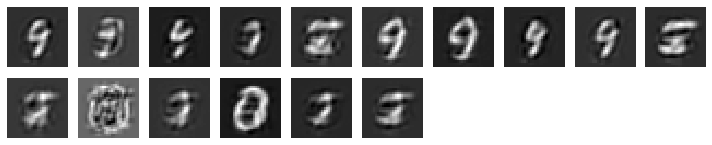

results after iter  11600  d_fake_as_real =  0.1976631134748459  support =  341.375


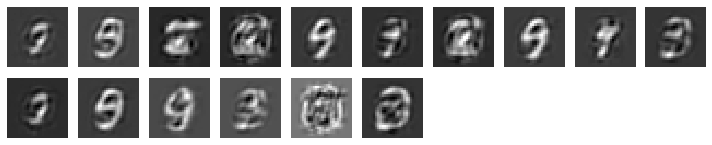

results after iter  11700  d_fake_as_real =  0.19303485751152039  support =  306.625


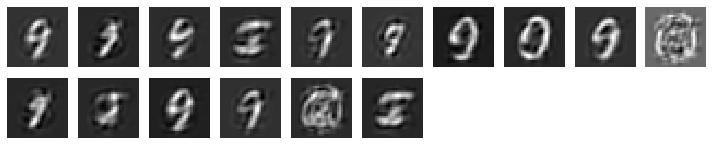

results after iter  11800  d_fake_as_real =  0.19128364324569702  support =  299.0625


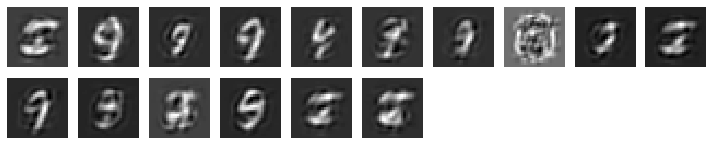

results after iter  11900  d_fake_as_real =  0.193607360124588  support =  251.1875


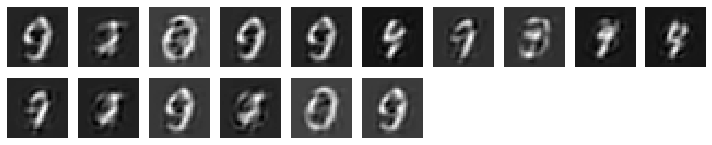

results after iter  12000  d_fake_as_real =  0.1961602121591568  support =  284.6875


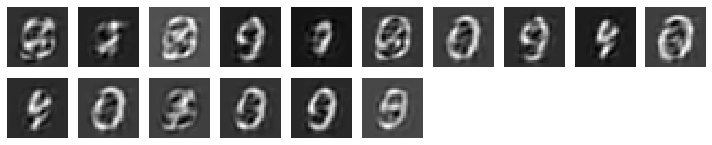

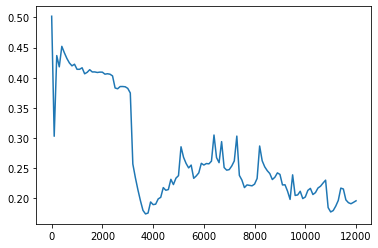

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  12100  d_fake_as_real =  0.20983567833900452  support =  252.125


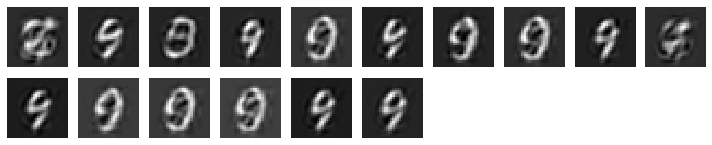

results after iter  12200  d_fake_as_real =  0.20696520805358887  support =  263.0625


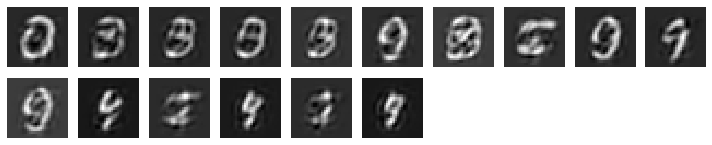

results after iter  12300  d_fake_as_real =  0.2051771879196167  support =  373.1875


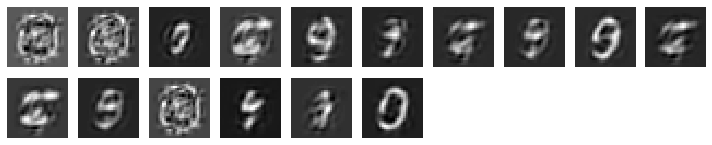

results after iter  12400  d_fake_as_real =  0.21340477466583252  support =  291.25


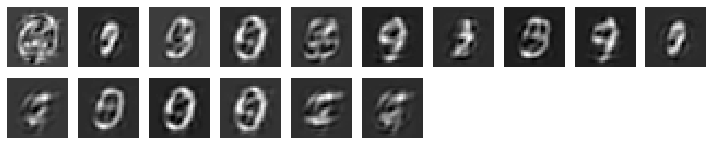

results after iter  12500  d_fake_as_real =  0.22607266902923584  support =  281.625


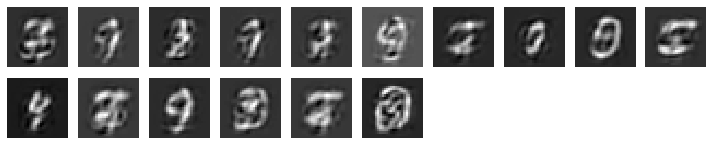

results after iter  12600  d_fake_as_real =  0.21464067697525024  support =  338.1875


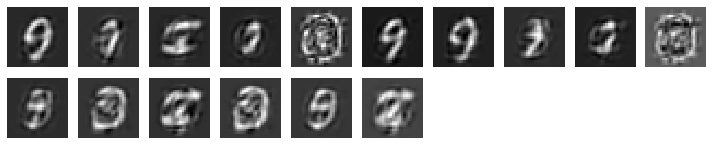

results after iter  12700  d_fake_as_real =  0.2207709550857544  support =  240.0


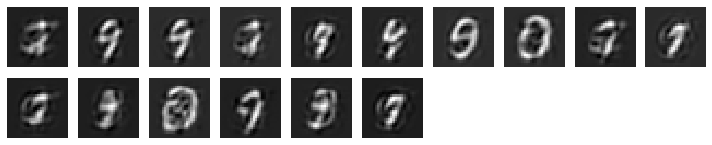

results after iter  12800  d_fake_as_real =  0.22276510298252106  support =  272.0625


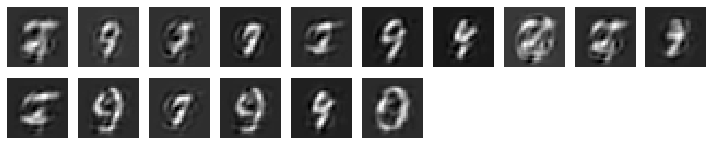

results after iter  12900  d_fake_as_real =  0.2108028382062912  support =  253.9375


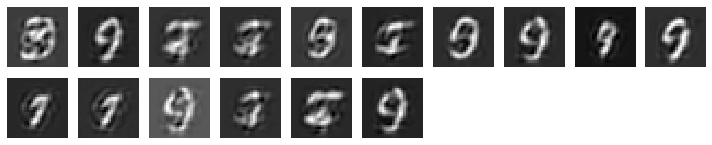

results after iter  13000  d_fake_as_real =  0.2158600091934204  support =  253.25


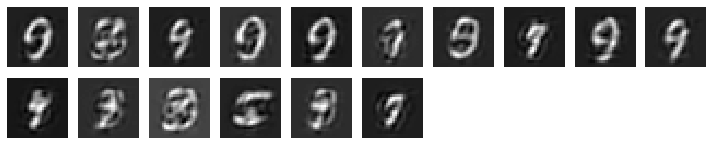

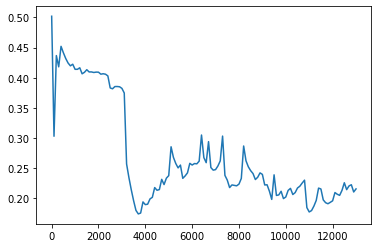

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  13100  d_fake_as_real =  0.2263423651456833  support =  276.4375


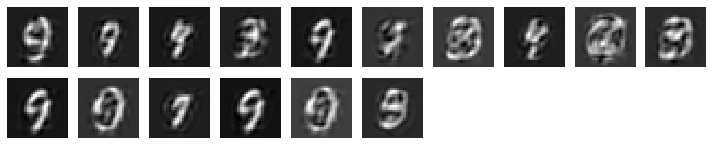

results after iter  13200  d_fake_as_real =  0.2153303474187851  support =  318.0625


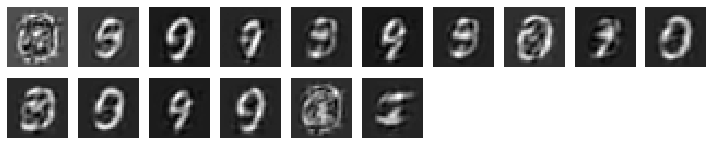

results after iter  13300  d_fake_as_real =  0.23914551734924316  support =  246.0


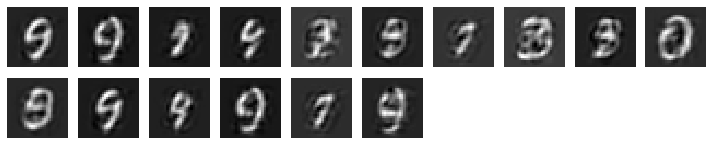

results after iter  13400  d_fake_as_real =  0.21991325914859772  support =  320.875


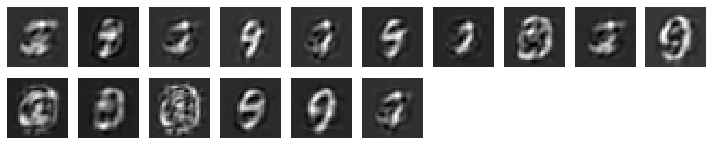

results after iter  13500  d_fake_as_real =  0.2082034945487976  support =  312.625


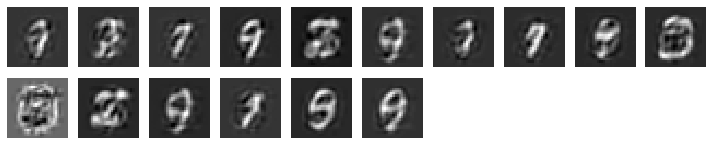

results after iter  13600  d_fake_as_real =  0.20612984895706177  support =  288.625


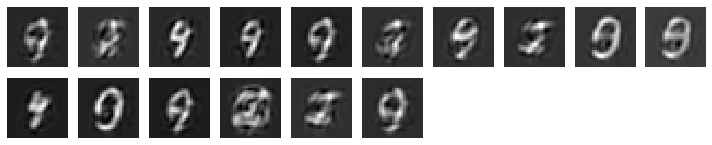

results after iter  13700  d_fake_as_real =  0.2134651243686676  support =  266.375


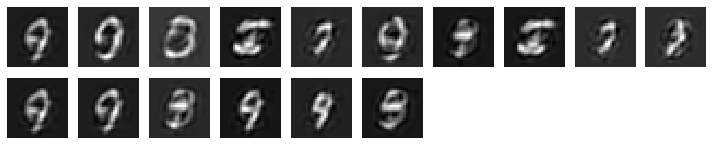

results after iter  13800  d_fake_as_real =  0.2044391632080078  support =  251.4375


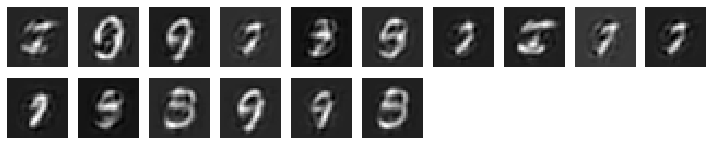

results after iter  13900  d_fake_as_real =  0.19666998088359833  support =  343.0625


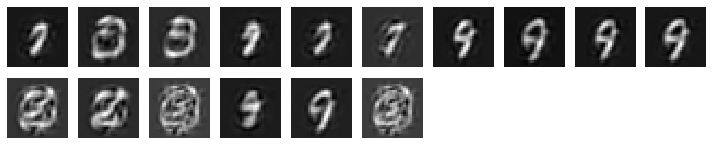

results after iter  14000  d_fake_as_real =  0.20695430040359497  support =  248.25


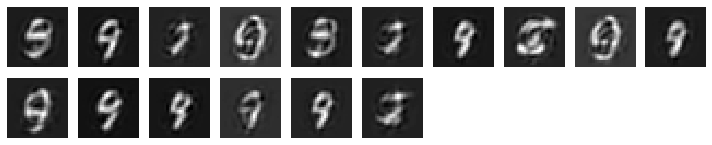

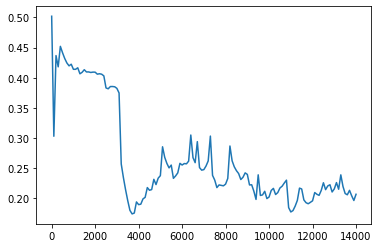

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  14100  d_fake_as_real =  0.2122059166431427  support =  228.6875


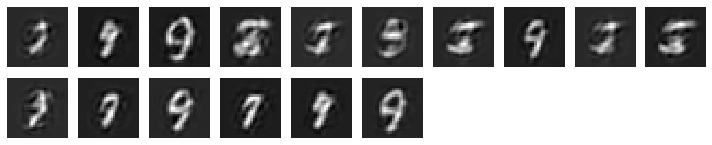

results after iter  14200  d_fake_as_real =  0.2387922704219818  support =  334.75


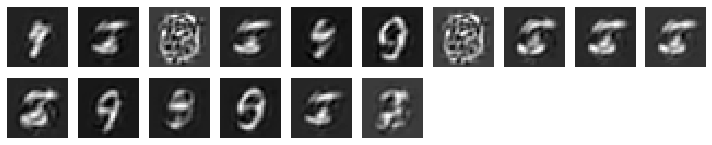

results after iter  14300  d_fake_as_real =  0.20270970463752747  support =  317.0


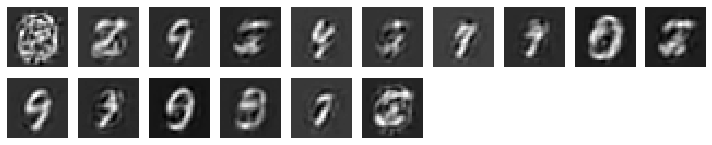

results after iter  14400  d_fake_as_real =  0.18768788874149323  support =  337.125


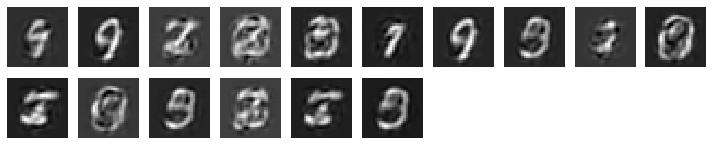

results after iter  14500  d_fake_as_real =  0.18888485431671143  support =  286.125


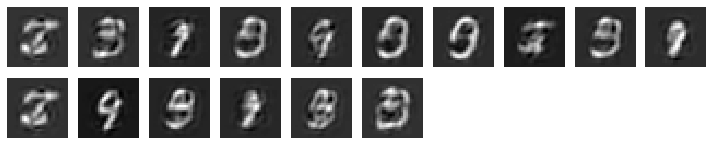

results after iter  14600  d_fake_as_real =  0.19511649012565613  support =  273.75


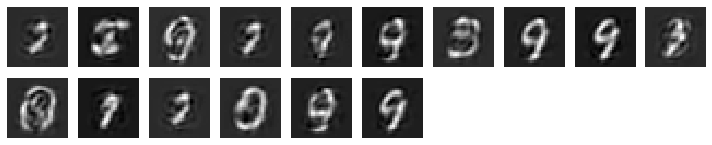

results after iter  14700  d_fake_as_real =  0.18179824948310852  support =  357.3125


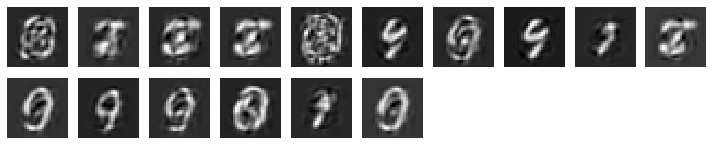

results after iter  14800  d_fake_as_real =  0.1752607822418213  support =  252.375


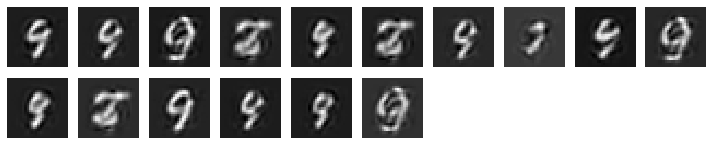

results after iter  14900  d_fake_as_real =  0.19752900302410126  support =  287.4375


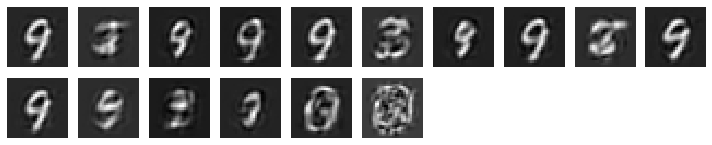

Epoch: 3 	 Discriminator Loss_fake: 0.3743712306022644 	 Discriminator Loss_real: 0.04265644773840904		 Generator Loss: [7.820813, 5.790333, 0.19943087]


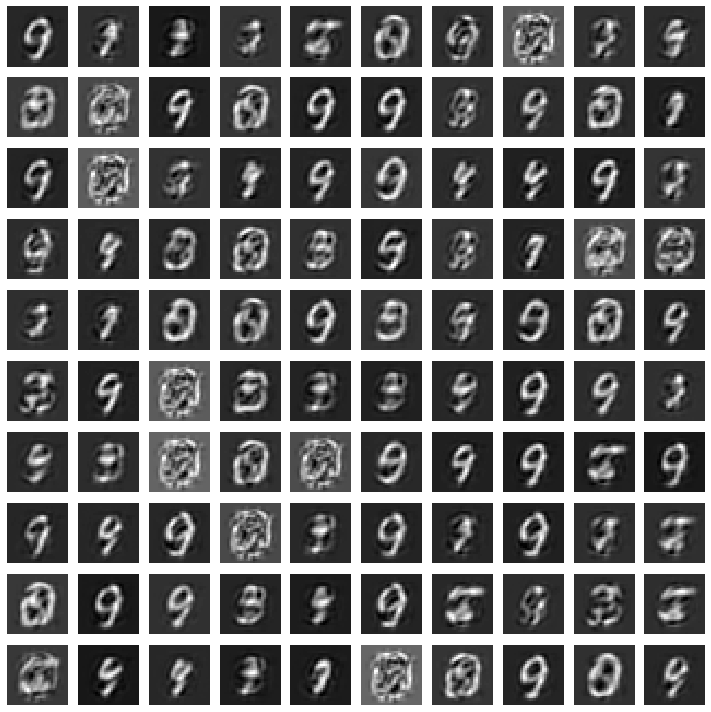

results after iter  15000  d_fake_as_real =  0.17700637876987457  support =  291.9375


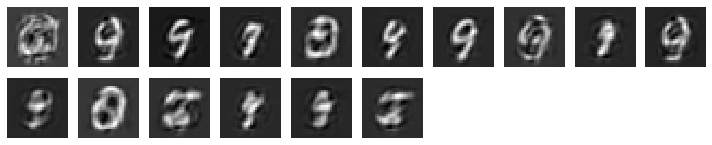

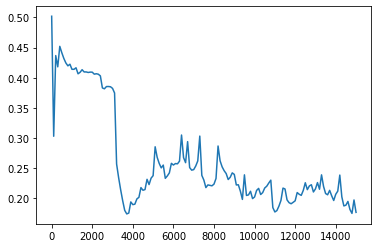

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  15100  d_fake_as_real =  0.18050339818000793  support =  264.875


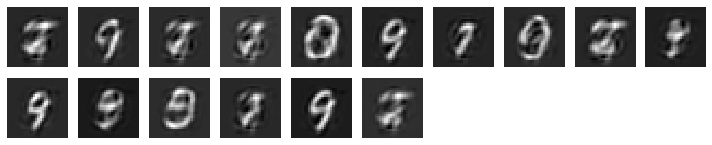

results after iter  15200  d_fake_as_real =  0.18576012551784515  support =  258.9375


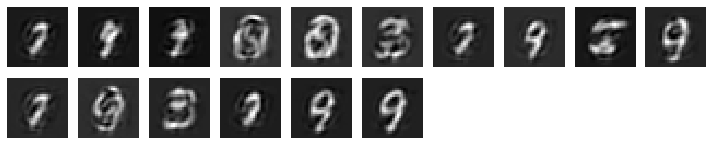

results after iter  15300  d_fake_as_real =  0.18897664546966553  support =  334.0


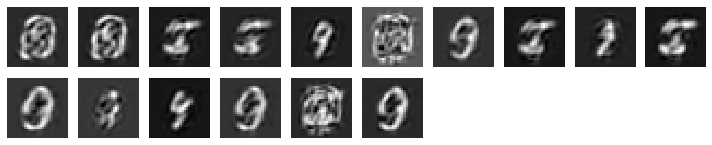

results after iter  15400  d_fake_as_real =  0.19291651248931885  support =  291.75


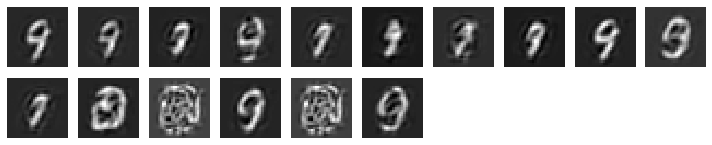

results after iter  15500  d_fake_as_real =  0.20160193741321564  support =  246.0


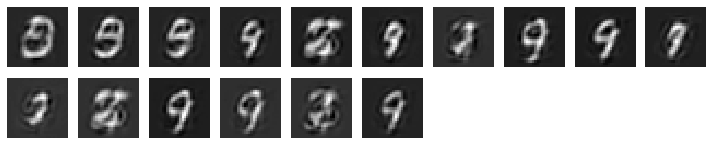

results after iter  15600  d_fake_as_real =  0.21978133916854858  support =  274.3125


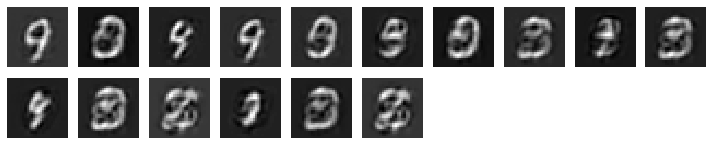

results after iter  15700  d_fake_as_real =  0.19004520773887634  support =  271.1875


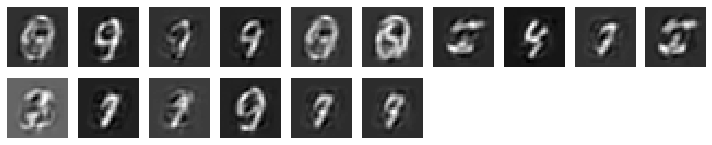

results after iter  15800  d_fake_as_real =  0.1777367889881134  support =  290.8125


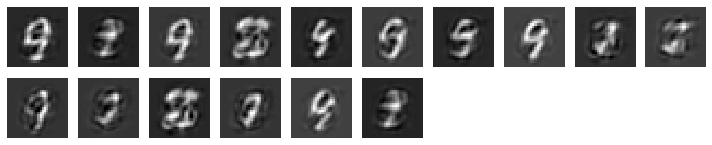

results after iter  15900  d_fake_as_real =  0.1872791349887848  support =  309.5625


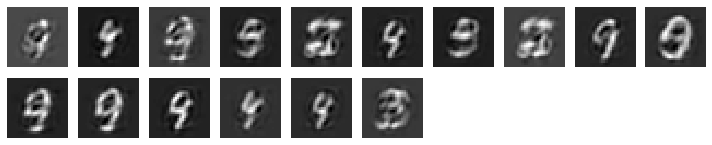

results after iter  16000  d_fake_as_real =  0.21123114228248596  support =  349.0625


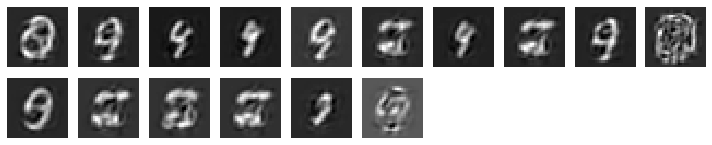

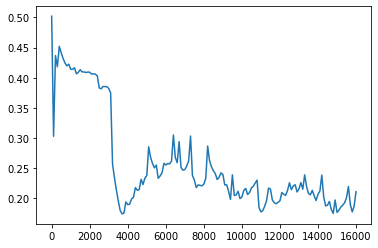

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  16100  d_fake_as_real =  0.18060189485549927  support =  298.5625


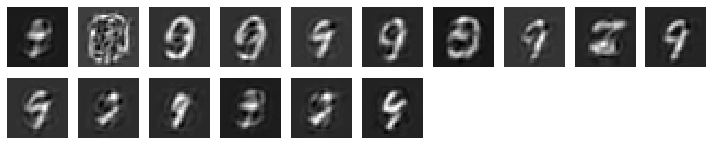

results after iter  16200  d_fake_as_real =  0.18536841869354248  support =  270.0625


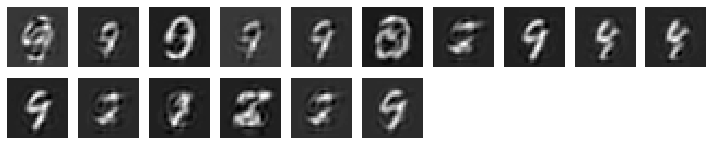

results after iter  16300  d_fake_as_real =  0.18210358917713165  support =  312.0625


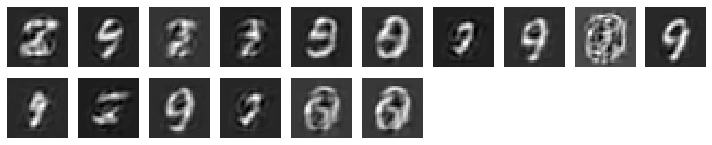

results after iter  16400  d_fake_as_real =  0.18596456944942474  support =  259.9375


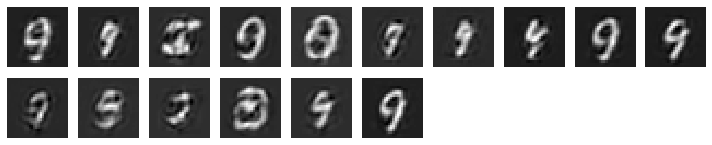

results after iter  16500  d_fake_as_real =  0.19467002153396606  support =  260.0


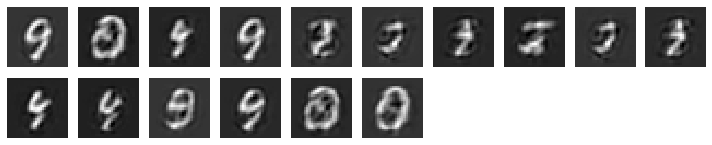

results after iter  16600  d_fake_as_real =  0.22148574888706207  support =  322.9375


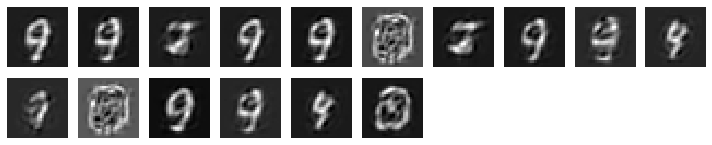

results after iter  16700  d_fake_as_real =  0.1948787122964859  support =  310.75


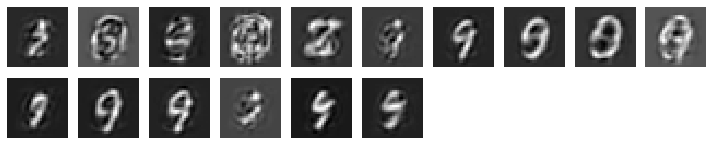

results after iter  16800  d_fake_as_real =  0.1982986330986023  support =  297.375


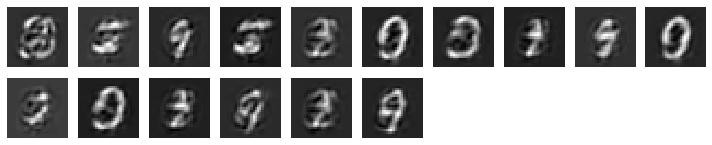

results after iter  16900  d_fake_as_real =  0.22463786602020264  support =  302.75


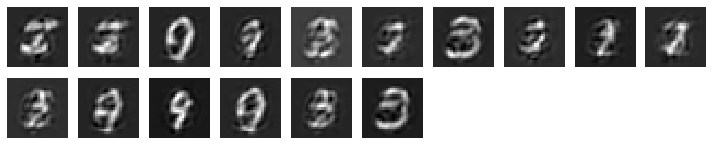

results after iter  17000  d_fake_as_real =  0.19624164700508118  support =  298.4375


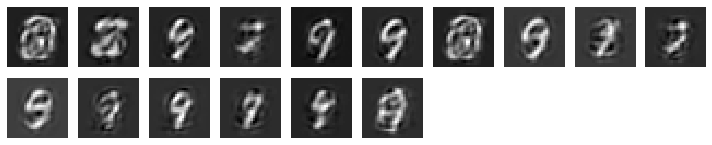

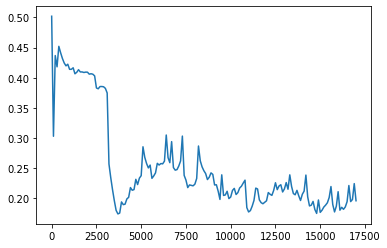

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  17100  d_fake_as_real =  0.18763190507888794  support =  349.5625


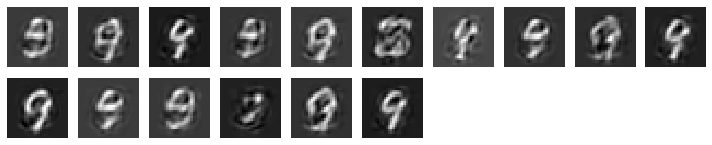

results after iter  17200  d_fake_as_real =  0.1850457489490509  support =  426.875


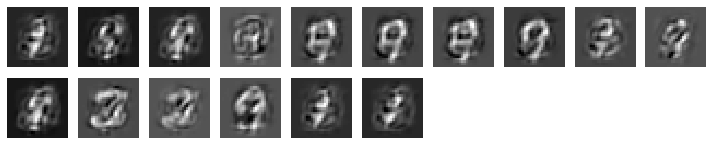

results after iter  17300  d_fake_as_real =  0.18319696187973022  support =  433.0625


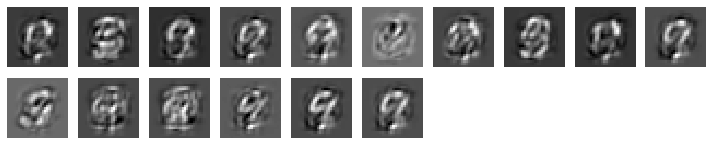

results after iter  17400  d_fake_as_real =  0.18541750311851501  support =  444.5625


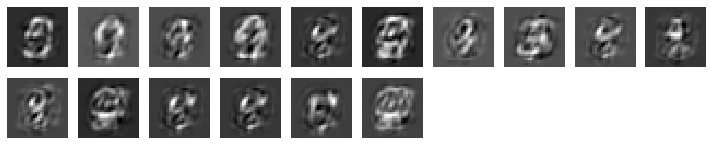

results after iter  17500  d_fake_as_real =  0.1326991617679596  support =  392.5625


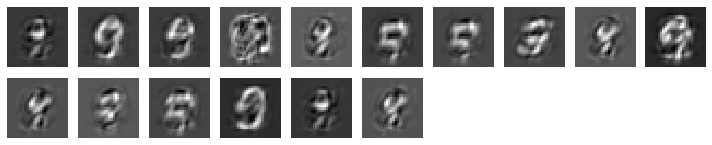

results after iter  17600  d_fake_as_real =  0.14595043659210205  support =  382.0625


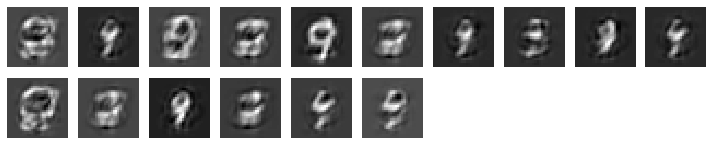

results after iter  17700  d_fake_as_real =  0.117164246737957  support =  369.3125


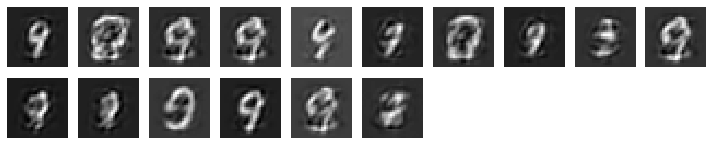

results after iter  17800  d_fake_as_real =  0.12192493677139282  support =  379.9375


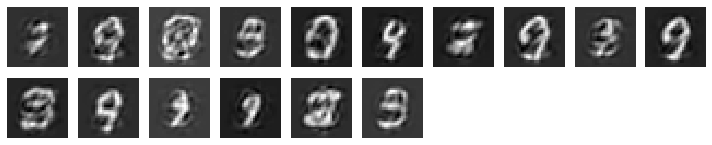

results after iter  17900  d_fake_as_real =  0.1366736888885498  support =  382.375


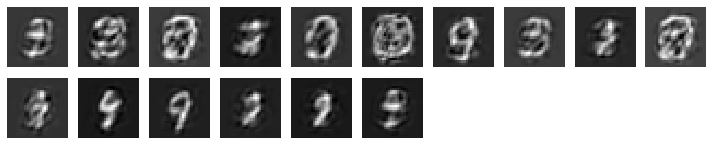

results after iter  18000  d_fake_as_real =  0.1356893926858902  support =  336.3125


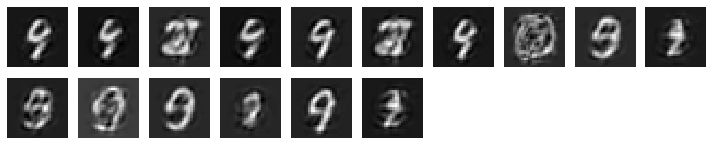

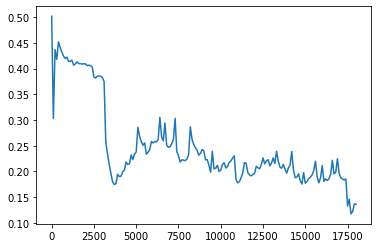

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  18100  d_fake_as_real =  0.140189990401268  support =  318.5625


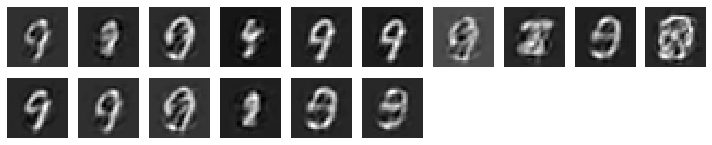

results after iter  18200  d_fake_as_real =  0.15873175859451294  support =  356.75


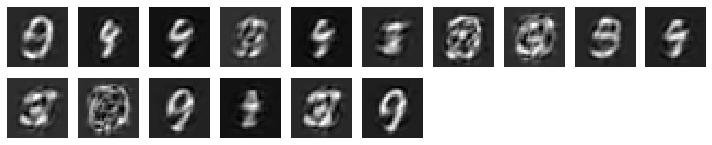

results after iter  18300  d_fake_as_real =  0.15664245188236237  support =  342.1875


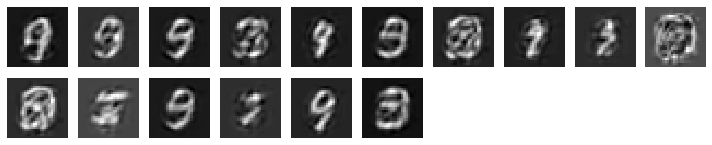

results after iter  18400  d_fake_as_real =  0.16926074028015137  support =  401.4375


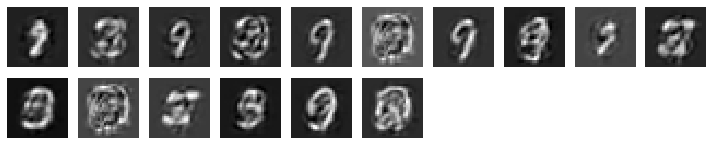

results after iter  18500  d_fake_as_real =  0.19929897785186768  support =  368.0625


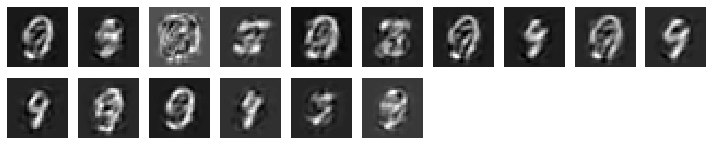

results after iter  18600  d_fake_as_real =  0.17221955955028534  support =  363.0


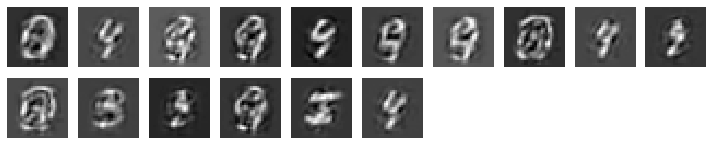

results after iter  18700  d_fake_as_real =  0.16716617345809937  support =  340.9375


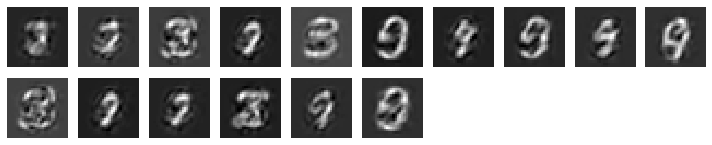

Epoch: 4 	 Discriminator Loss_fake: 0.3711508810520172 	 Discriminator Loss_real: 0.03783630207180977		 Generator Loss: [7.631661, 5.551774, 0.20465897]


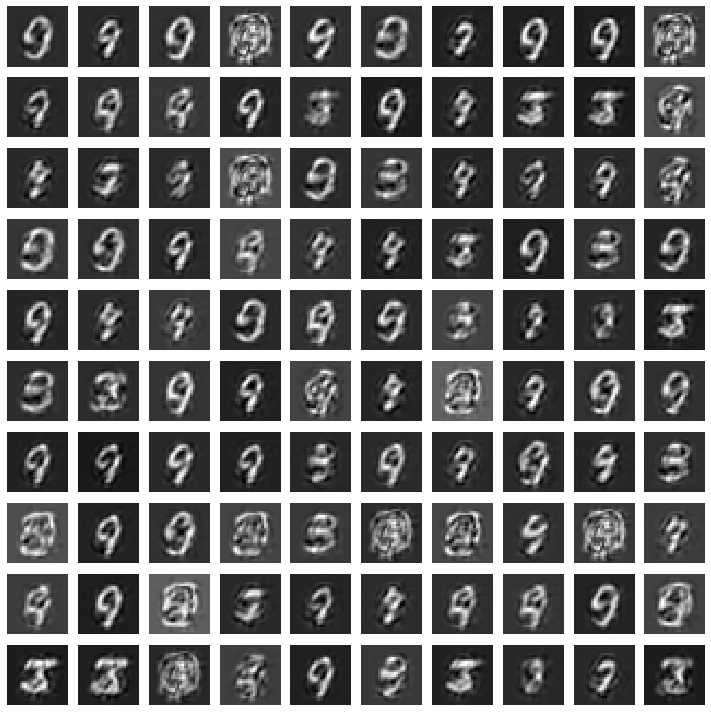

results after iter  18800  d_fake_as_real =  0.18918824195861816  support =  334.4375


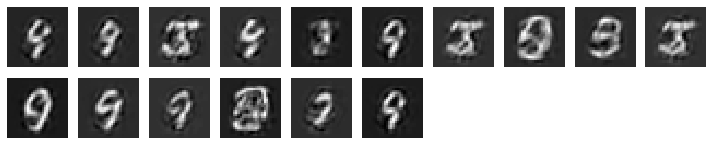

results after iter  18900  d_fake_as_real =  0.17081354558467865  support =  371.5625


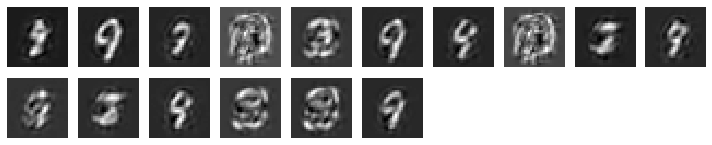

results after iter  19000  d_fake_as_real =  0.17436671257019043  support =  381.4375


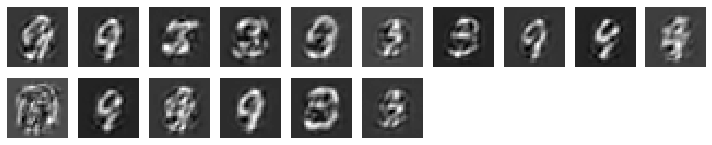

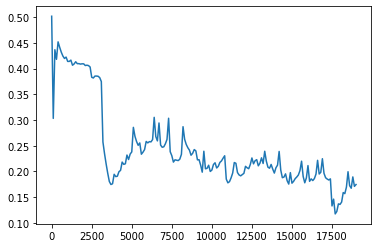

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  19100  d_fake_as_real =  0.1756928563117981  support =  368.25


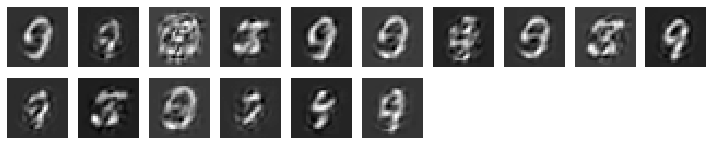

results after iter  19200  d_fake_as_real =  0.1830470860004425  support =  329.625


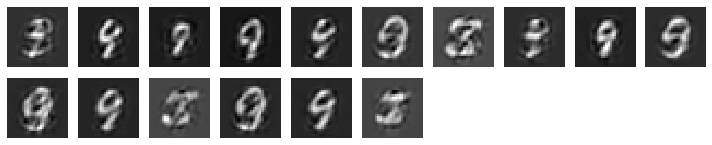

results after iter  19300  d_fake_as_real =  0.17901435494422913  support =  338.75


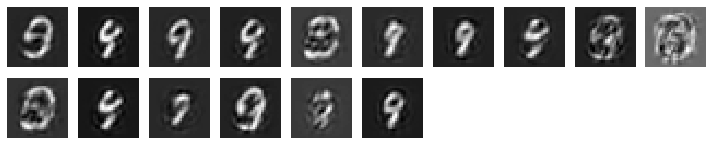

results after iter  19400  d_fake_as_real =  0.18029993772506714  support =  311.6875


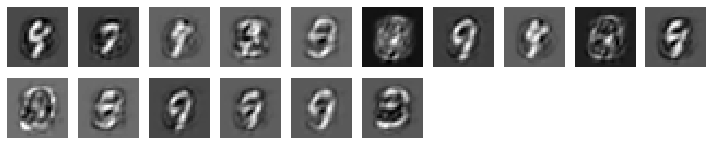

results after iter  19500  d_fake_as_real =  0.18417194485664368  support =  313.5625


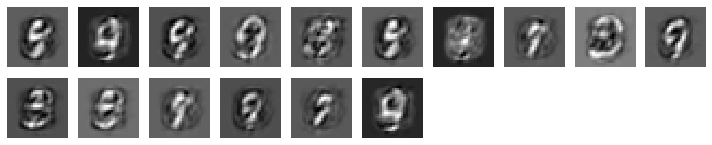

results after iter  19600  d_fake_as_real =  0.18666747212409973  support =  331.625


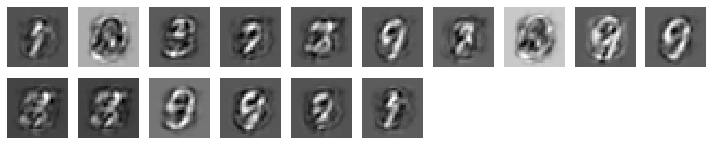

results after iter  19700  d_fake_as_real =  0.19081124663352966  support =  324.875


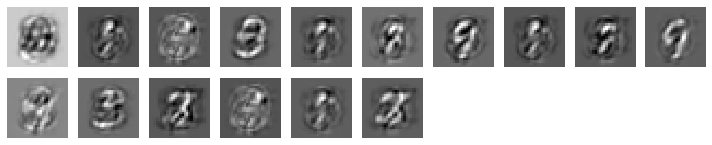

results after iter  19800  d_fake_as_real =  0.19610759615898132  support =  290.4375


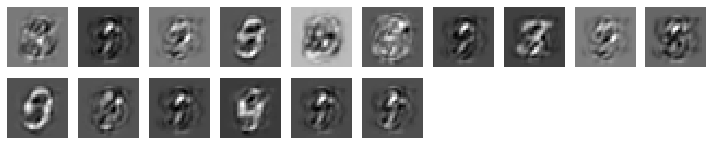

results after iter  19900  d_fake_as_real =  0.2008964866399765  support =  293.3125


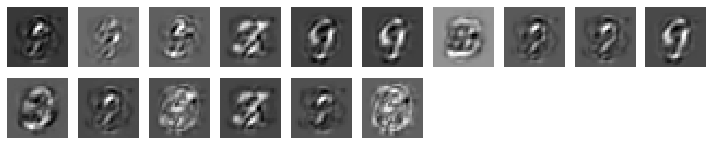

results after iter  20000  d_fake_as_real =  0.20242741703987122  support =  246.5


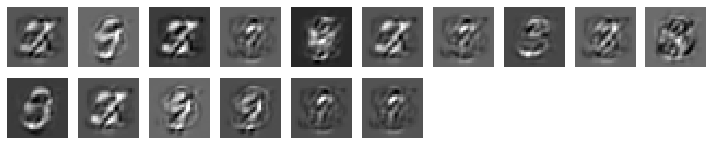

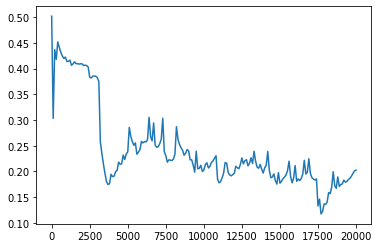

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  20100  d_fake_as_real =  0.2040197253227234  support =  246.1875


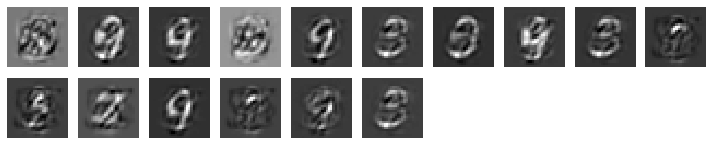

results after iter  20200  d_fake_as_real =  0.20329612493515015  support =  260.4375


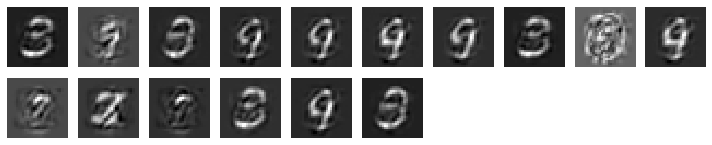

results after iter  20300  d_fake_as_real =  0.13870614767074585  support =  382.875


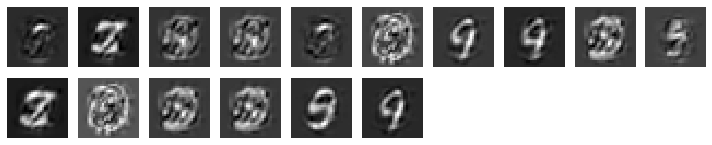

results after iter  20400  d_fake_as_real =  0.12143895030021667  support =  288.0625


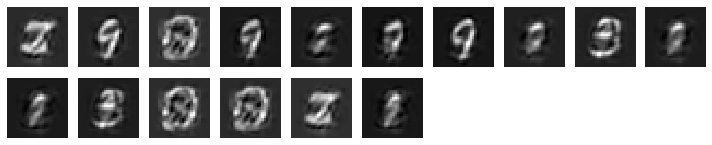

results after iter  20500  d_fake_as_real =  0.08347628265619278  support =  360.25


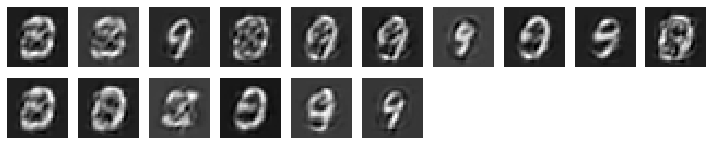

results after iter  20600  d_fake_as_real =  0.07976602017879486  support =  349.25


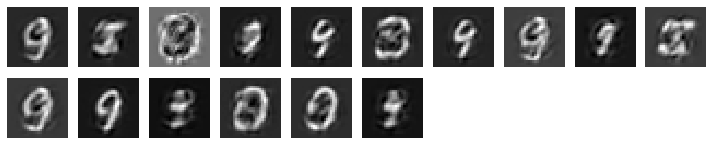

results after iter  20700  d_fake_as_real =  0.08432500809431076  support =  336.6875


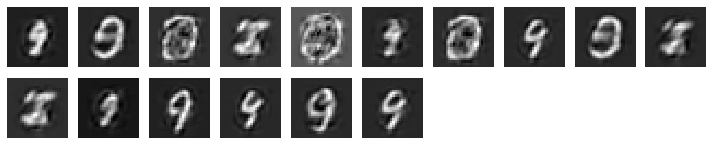

results after iter  20800  d_fake_as_real =  0.08065059036016464  support =  347.75


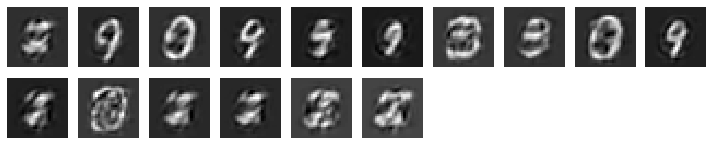

results after iter  20900  d_fake_as_real =  0.09699440002441406  support =  360.6875


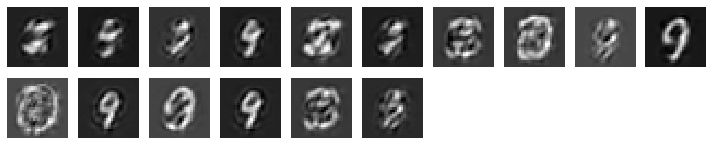

results after iter  21000  d_fake_as_real =  0.09094108641147614  support =  358.8125


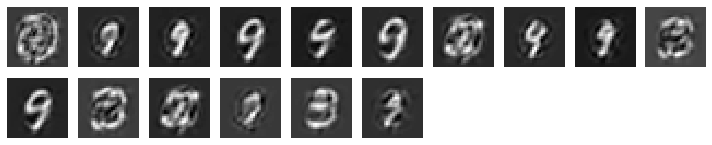

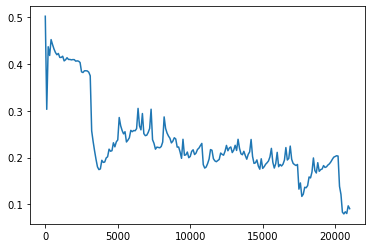

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  21100  d_fake_as_real =  0.0970403254032135  support =  305.1875


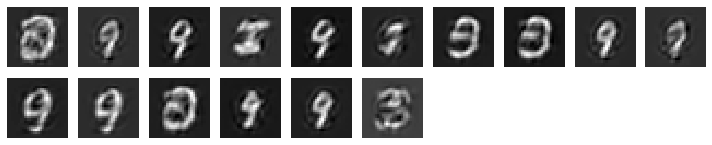

results after iter  21200  d_fake_as_real =  0.10932767391204834  support =  328.8125


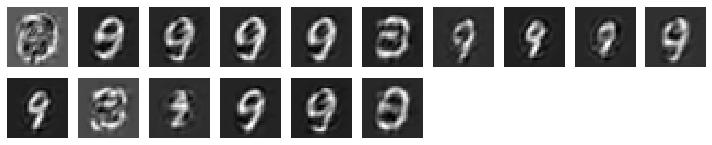

results after iter  21300  d_fake_as_real =  0.16027702391147614  support =  325.5


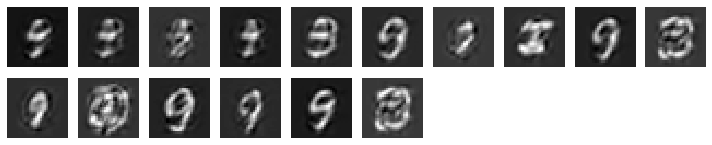

results after iter  21400  d_fake_as_real =  0.13220733404159546  support =  337.125


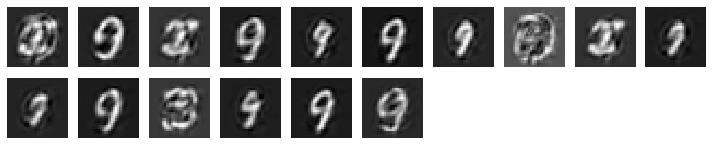

results after iter  21500  d_fake_as_real =  0.13511742651462555  support =  324.375


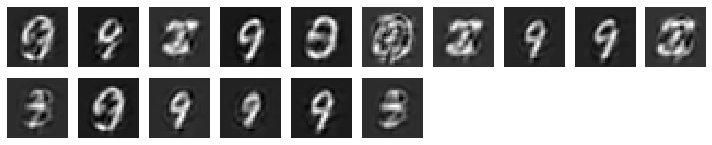

results after iter  21600  d_fake_as_real =  0.13438139855861664  support =  323.9375


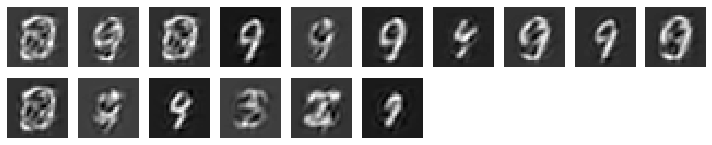

results after iter  21700  d_fake_as_real =  0.1367475390434265  support =  378.5


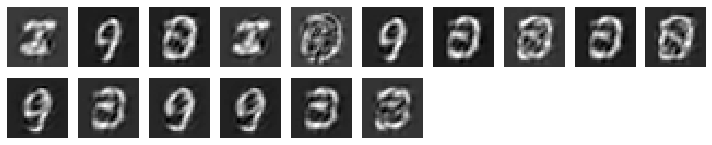

results after iter  21800  d_fake_as_real =  0.1424388587474823  support =  339.625


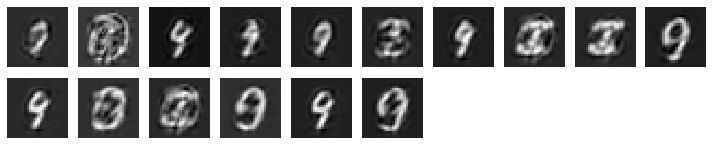

results after iter  21900  d_fake_as_real =  0.1579762101173401  support =  315.3125


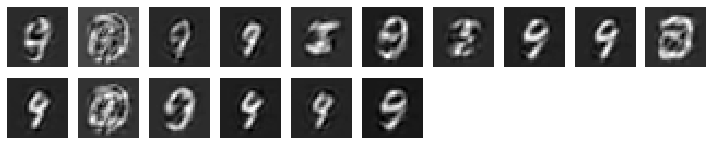

results after iter  22000  d_fake_as_real =  0.15379846096038818  support =  324.8125


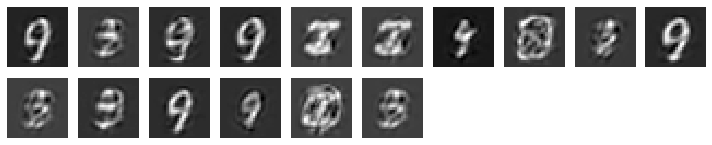

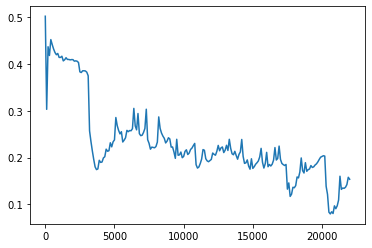

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  22100  d_fake_as_real =  0.15846139192581177  support =  288.75


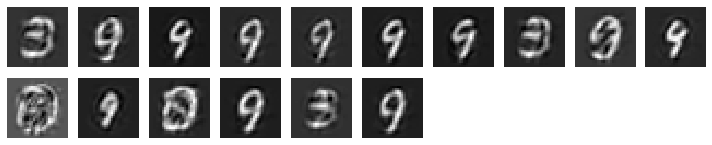

results after iter  22200  d_fake_as_real =  0.16214290261268616  support =  403.25


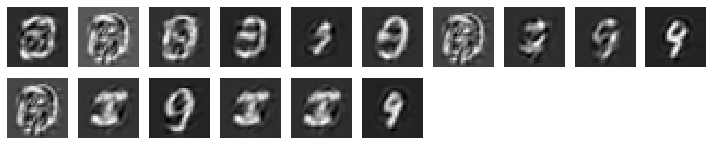

results after iter  22300  d_fake_as_real =  0.23134630918502808  support =  355.25


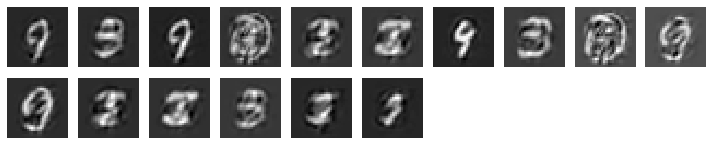

results after iter  22400  d_fake_as_real =  0.2019471526145935  support =  348.3125


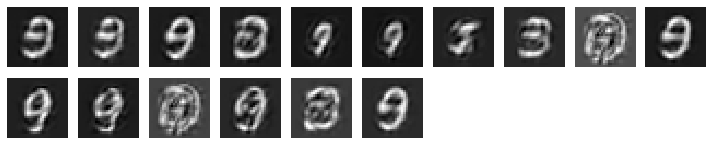

Epoch: 5 	 Discriminator Loss_fake: 0.3741112947463989 	 Discriminator Loss_real: 0.041201308369636536		 Generator Loss: [6.7779646, 4.75725, 0.19815153]


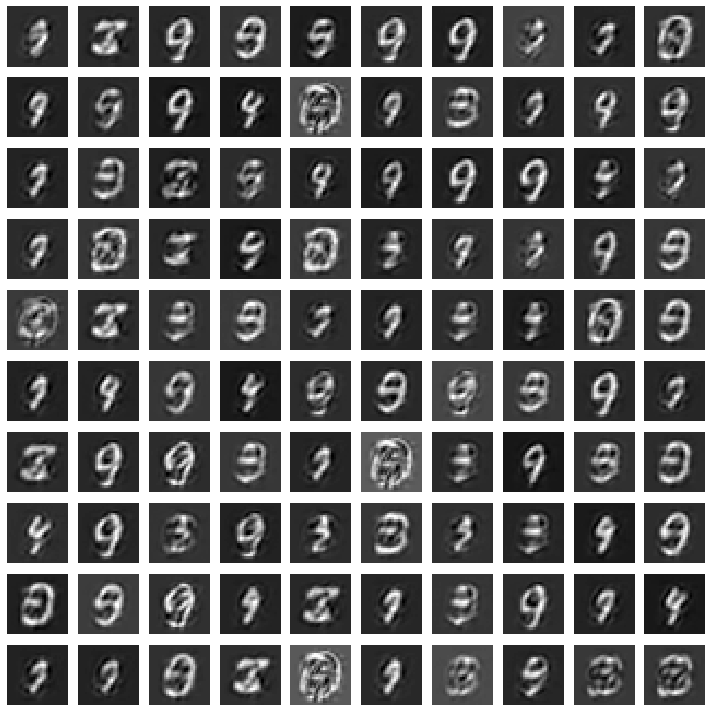

results after iter  22500  d_fake_as_real =  0.1811370849609375  support =  326.125


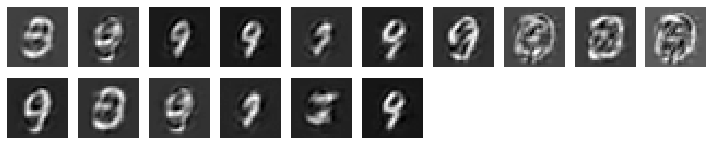

results after iter  22600  d_fake_as_real =  0.17005756497383118  support =  303.9375


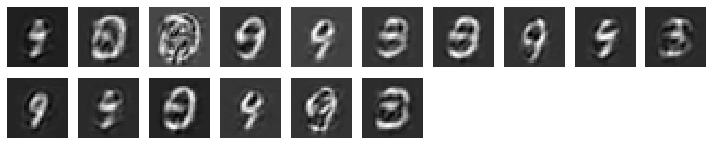

results after iter  22700  d_fake_as_real =  0.1685096025466919  support =  278.4375


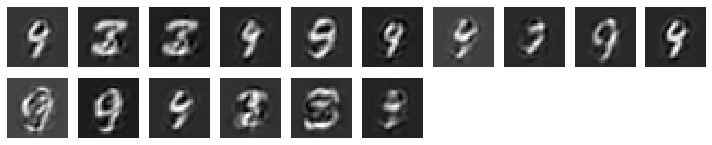

results after iter  22800  d_fake_as_real =  0.1707146167755127  support =  311.5625


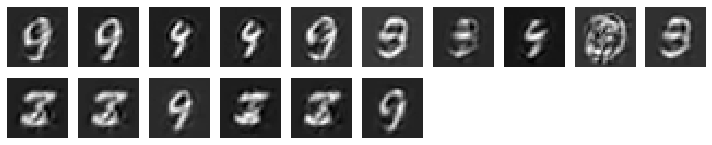

results after iter  22900  d_fake_as_real =  0.17644408345222473  support =  319.875


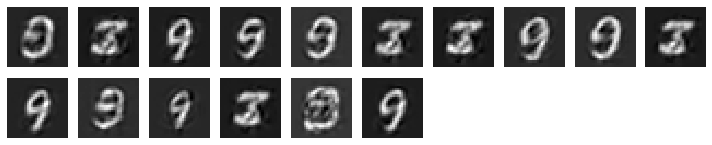

results after iter  23000  d_fake_as_real =  0.15292847156524658  support =  320.125


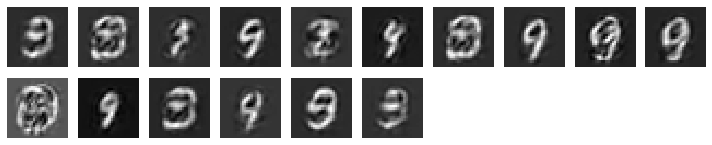

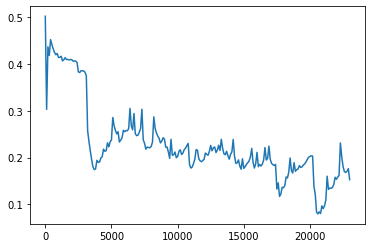

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  23100  d_fake_as_real =  0.13818037509918213  support =  273.0625


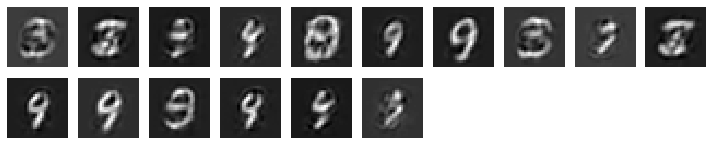

results after iter  23200  d_fake_as_real =  0.1383884847164154  support =  337.6875


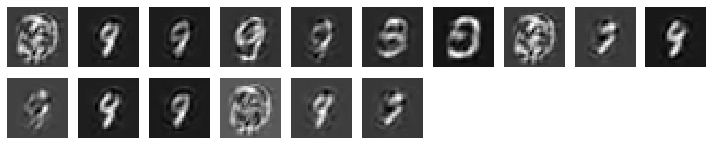

results after iter  23300  d_fake_as_real =  0.12765604257583618  support =  286.875


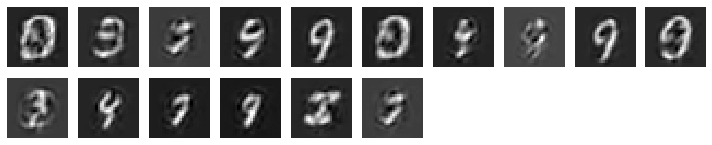

results after iter  23400  d_fake_as_real =  0.1331479847431183  support =  311.625


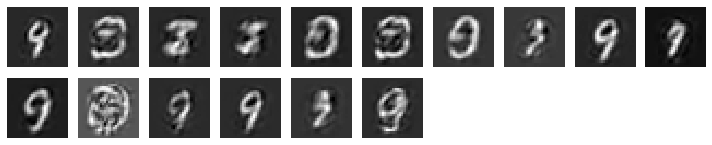

results after iter  23500  d_fake_as_real =  0.13206203281879425  support =  347.4375


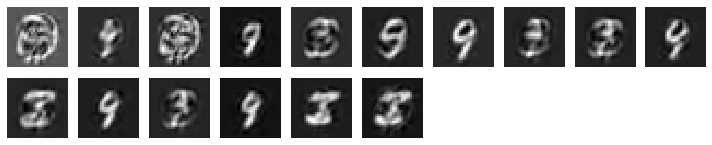

results after iter  23600  d_fake_as_real =  0.13356494903564453  support =  255.125


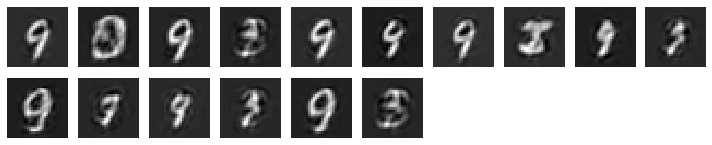

results after iter  23700  d_fake_as_real =  0.1408597230911255  support =  275.8125


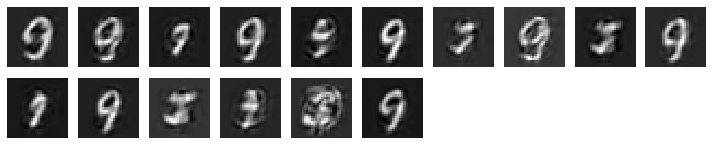

results after iter  23800  d_fake_as_real =  0.1720784306526184  support =  351.9375


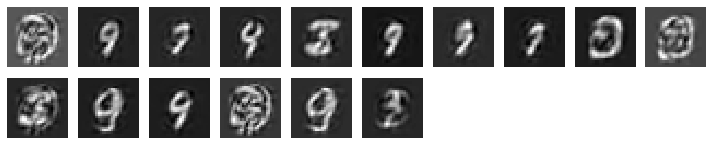

results after iter  23900  d_fake_as_real =  0.15647554397583008  support =  291.0


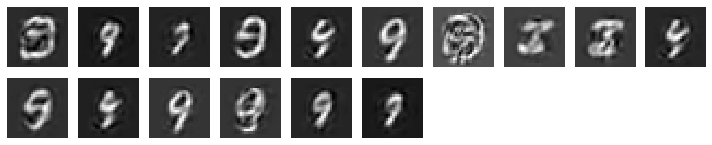

results after iter  24000  d_fake_as_real =  0.1551896184682846  support =  294.0625


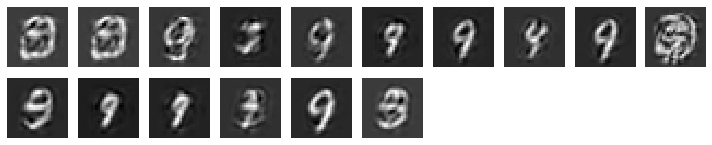

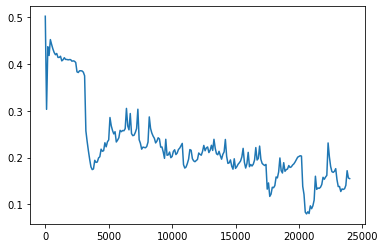

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  24100  d_fake_as_real =  0.16010528802871704  support =  339.875


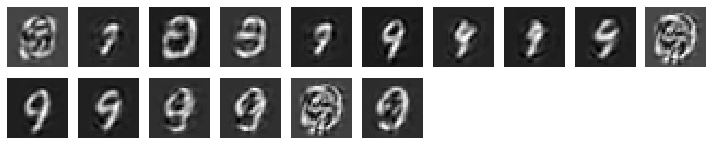

results after iter  24200  d_fake_as_real =  0.16517864167690277  support =  281.3125


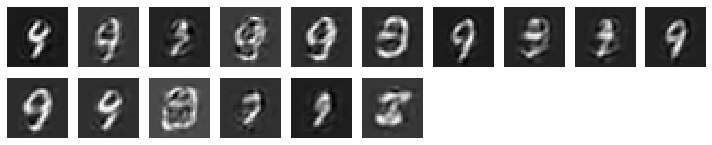

results after iter  24300  d_fake_as_real =  0.15359562635421753  support =  340.375


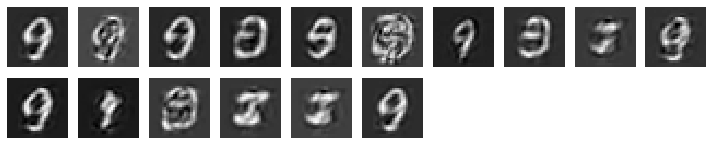

results after iter  24400  d_fake_as_real =  0.15422862768173218  support =  317.5


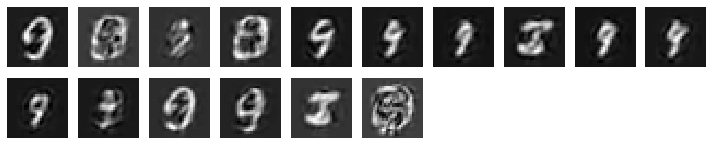

results after iter  24500  d_fake_as_real =  0.16395717859268188  support =  312.5


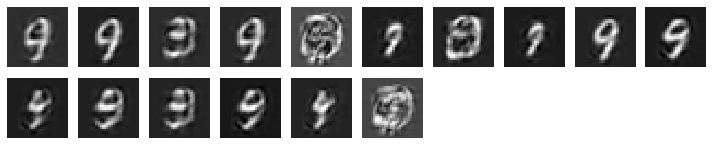

results after iter  24600  d_fake_as_real =  0.1638125479221344  support =  303.1875


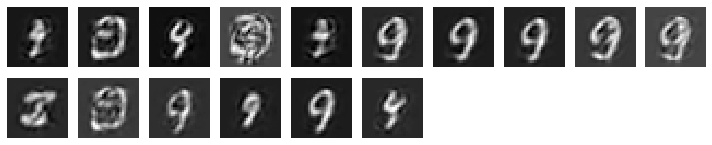

results after iter  24700  d_fake_as_real =  0.16924773156642914  support =  308.5


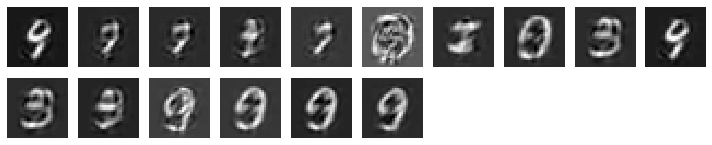

results after iter  24800  d_fake_as_real =  0.17793667316436768  support =  263.8125


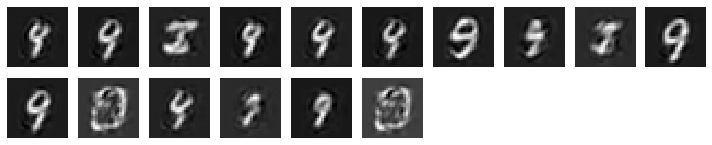

results after iter  24900  d_fake_as_real =  0.18531712889671326  support =  281.3125


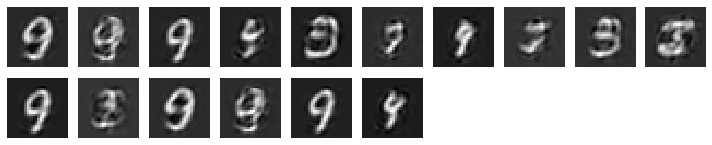

results after iter  25000  d_fake_as_real =  0.21129482984542847  support =  304.6875


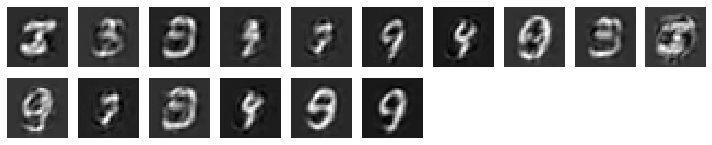

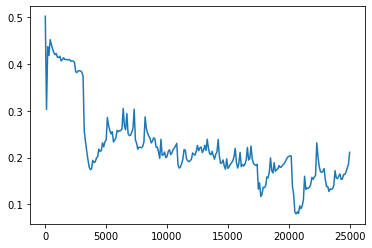

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  25100  d_fake_as_real =  0.22429360449314117  support =  306.75


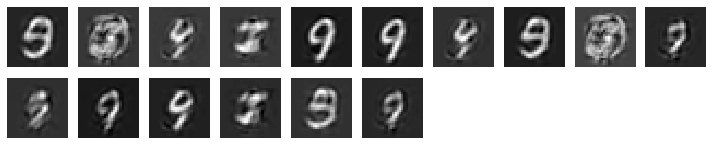

results after iter  25200  d_fake_as_real =  0.20037655532360077  support =  283.4375


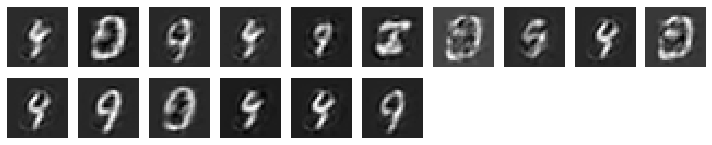

results after iter  25300  d_fake_as_real =  0.19288823008537292  support =  304.4375


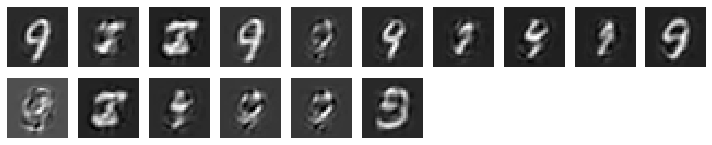

results after iter  25400  d_fake_as_real =  0.1947506219148636  support =  300.25


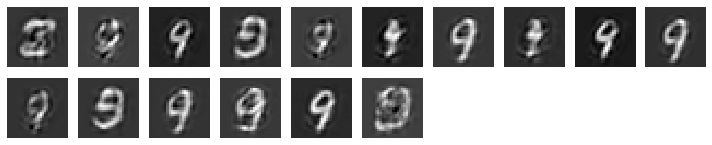

results after iter  25500  d_fake_as_real =  0.19672554731369019  support =  320.6875


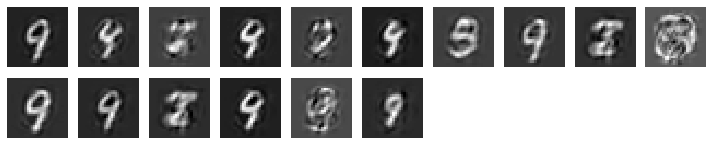

results after iter  25600  d_fake_as_real =  0.16923169791698456  support =  314.9375


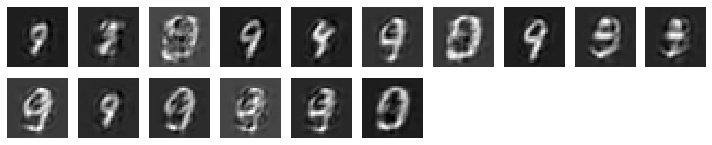

results after iter  25700  d_fake_as_real =  0.1995319426059723  support =  338.6875


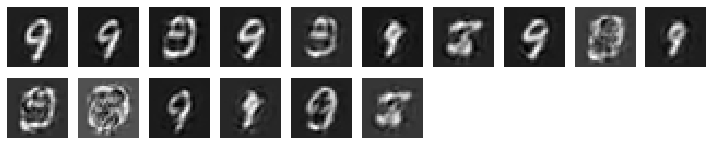

results after iter  25800  d_fake_as_real =  0.17532627284526825  support =  276.6875


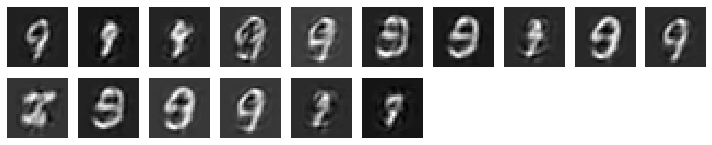

results after iter  25900  d_fake_as_real =  0.17851437628269196  support =  273.6875


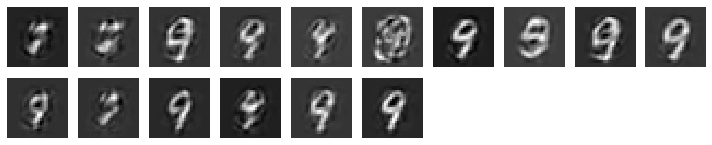

results after iter  26000  d_fake_as_real =  0.16683292388916016  support =  282.75


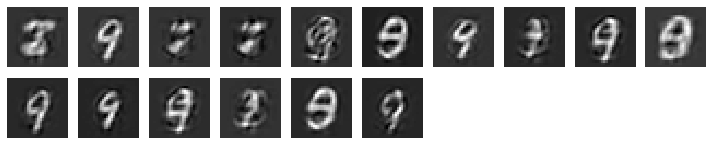

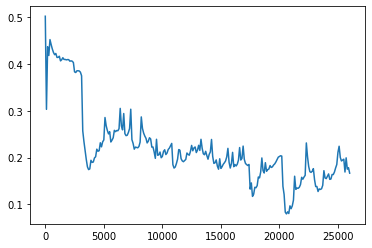

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


results after iter  26100  d_fake_as_real =  0.1644340306520462  support =  318.9375


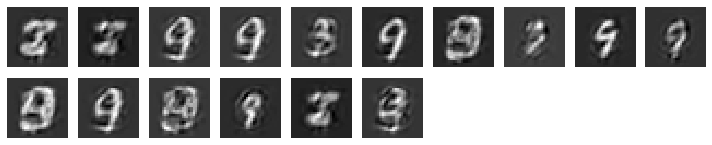

results after iter  26200  d_fake_as_real =  0.16406919062137604  support =  314.625


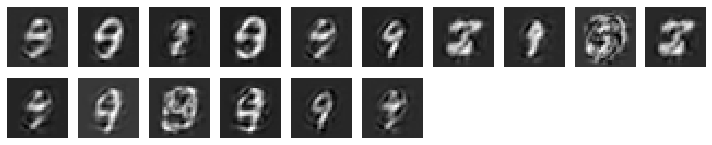

Epoch: 6 	 Discriminator Loss_fake: 0.35852882266044617 	 Discriminator Loss_real: 0.028412193059921265		 Generator Loss: [8.0758095, 6.0694284, 0.19801387]


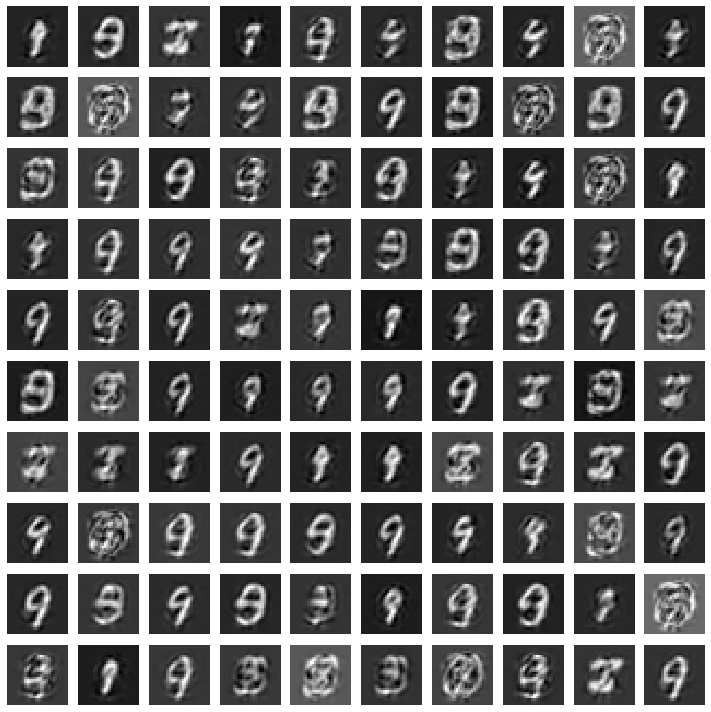

In [0]:
import matplotlib.pyplot as plt

n_d = 1 # 1 10 100
n_g = 1  # 1 10 100
n_r = 1  # 1 10 100

def count_support(sparse_mat):
  return (np.count_nonzero(sparse_mat))/batch_size


def show_images(noise):
    generated_images = generator.predict(noise)
    generated_images = np.matmul(dictionary_loaded2,np.transpose(generated_images))
    generated_images = np.transpose(generated_images)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

stop = False
fake_x = 0

def stop_criteria(fake_x):
  d_pred = np.sum(discriminator.predict(fake_x))/batch_size
  return d_pred >= 0.499

def d_ratio_on_fake(fake_x):
  return np.sum(discriminator.predict(fake_x))/batch_size

losses = np.array([])
iters= np.array([])

for epoch in range(10):  #epochs
    for iter in range(int(steps_per_epoch)):
      i = iter + int(epoch*(steps_per_epoch))
    # train D
      for batch in range(n_d):  #steps_per_epoch
          noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
          fake_x = generator.predict(noise) # create G(z)
          # fake is (batch_size,sparse_dim)
          
          fake_x = np.transpose(fake_x)
          # multiply by dict
          fake_x = np.matmul(dictionary_loaded2,fake_x)

          fake_x = np.transpose(fake_x)
          fake_x = fake_x.reshape(batch_size,img_rows,img_cols,channels)
          # fake_x is of size (batch,rows,cols,channels)

          real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)] # sample real image
          #remove below to return to FC scheme
          real_x = real_x.reshape(fake_x.shape)

          x = np.concatenate((real_x, fake_x))
          # x is of size (2*batch,rows,cols,channels)
          
          disc_y = np.zeros(2*batch_size)
          disc_y[:batch_size] = 0.9

          # train_on_batch recieves data and desired output
          d_loss_fake = discriminator.train_on_batch(x[:batch_size], disc_y[:batch_size])
          d_loss_real = discriminator.train_on_batch(x[batch_size:], disc_y[batch_size:])
          
          # check stop criteria
          if(epoch>0 and stop_criteria(x[:batch_size])):
            print("converged in epoch "+str(epoch))
            show_images(noise)
            stop = True
            break
      if(stop):
        break
      # print temp results
      if(i%100==0):
        losses = np.append(losses,d_ratio_on_fake(fake_x))
        iters =  np.append(iters,i)
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        print("results after iter ",i," d_fake_as_real = ",d_ratio_on_fake(fake_x)," support = " ,count_support(generator.predict(noise)))
        show_images(noise)
        if(i%1000==0):
          plt.plot(iters,losses)
          plt.show()
      # train G
      for batch in range(n_g):  #steps_per_epoch
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
        # train GAN (descriminator weights are fixed)
        y_gen_1 = np.ones(batch_size)
        y_gen_2 = np.zeros(batch_size * sparse_dim)
        y_gen_2 = y_gen_2.reshape(batch_size,sparse_dim)
        # TODO train the two outputs
        g_loss = gan.train_on_batch(noise, [y_gen_1,y_gen_2])
            
      # # train R
      # for batch in range(n_r):  #steps_per_epoch
      #   noise = np.random.normal(0, 1, size=(batch_size, noise_dim))  # will generate batch amount of noise vectors (gaussian distribution)
      #   r_loss = vae.train_on_batch(noise[:batch_size],noise[:batch_size])

    if(stop):
        break
    print(f'Epoch: {epoch} \t Discriminator Loss_fake: {d_loss_fake} \t Discriminator Loss_real: {d_loss_real}\t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(100, noise_dim))
    show_images(noise)







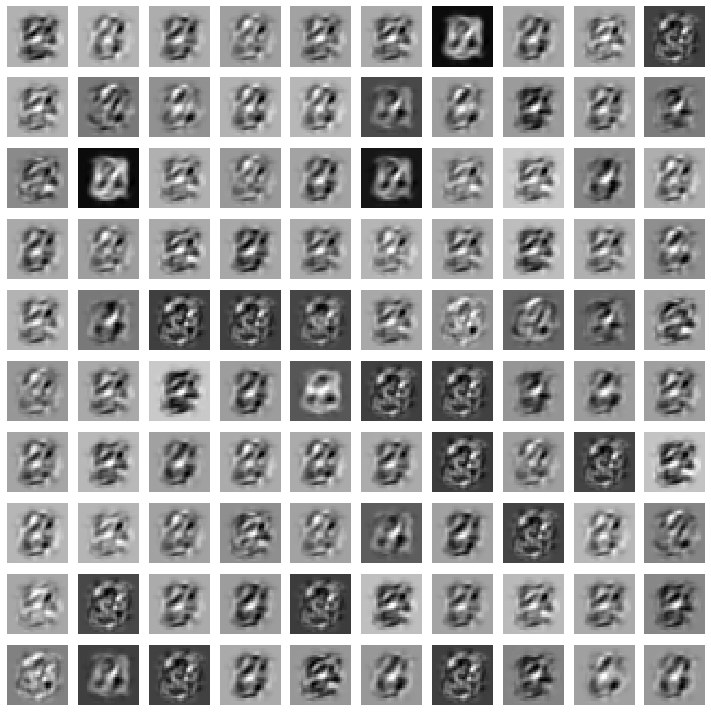

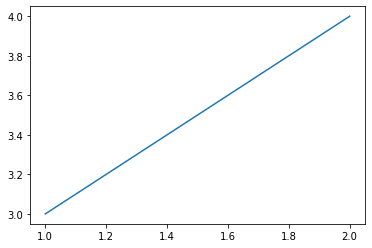

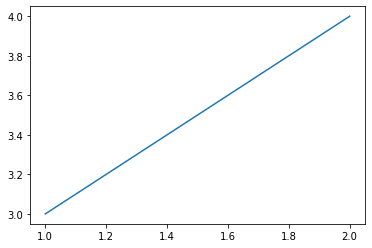

In [14]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)
